## Resourcing

Socrata does nevertheless have a catalog API, which, in every other respect, seems to be quite good. Chicago's [RSocrata client](https://github.com/Chicago/RSocrata) has an interface to it, but I'm a Python programmer, and [sodapy](https://github.com/xmunoz/sodapy) is dataset-specific. So I rolled my own, which I may have developed into a full module by the time you read this.

Here are the definitions I use:

* **Endpoint**: Any Socrata resource.
* **Dataset**: Any tabular or geospatial endpoint on Socrata.
* **Table**: A tabular dataset.

## Getting the Data

In [78]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
endpoints = json.loads(open("../data/portal_contents_raw.json").read())

In [3]:
tabular_datasets = [d for d in endpoints if d['resource']['type'] == 'dataset']

In [4]:
datasets = json.loads(open("../data/datasets.json").read())

In [5]:
pd.Series([d['resource']['type'] for d in endpoints]).value_counts()

filter      5242
map         1206
dataset     1073
chart        330
href         174
file          92
datalens      21
calendar       6
story          1
dtype: int64

In [6]:
# Run this to redo the Socrata data dump.
# Note: this takes a while to execute.
# !python ../src/dump_data.py

Here is the structure of the metadata response we get from the Socrata API pull:

In [7]:
endpoints[0]

{'classification': {'categories': ['finance',
   'environment',
   'housing & development'],
  'domain_category': 'Housing & Development',
  'domain_metadata': [{'key': 'Update_Automation', 'value': 'Yes'},
   {'key': 'Update_Update-Frequency', 'value': 'Daily'},
   {'key': 'Dataset-Information_Agency',
    'value': 'Department of Buildings (DOB)'}],
  'domain_tags': ['buildings', 'dob', 'job'],
  'tags': []},
 'link': 'https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2',
 'metadata': {'domain': 'data.cityofnewyork.us'},
 'permalink': 'https://data.cityofnewyork.us/d/ic3t-wcy2',
 'resource': {'attribution': 'Department of Buildings (DOB)',
  'columns_description': ['Loft Board',
   "Owner's  Phone #",
   'Date when job is assigned to plan examiner',
   'Date when job is prefiled',
   'Existing Height',
   'City ',
   'Zoning Distr 1',
   'House Number of Residence or Commercial Property',
   'Number assigned by City Planning to a specific building',

## Counts

**Endpoints**

In [8]:
len(endpoints)

8145

**Datasets**

In [9]:
len(datasets)

1486

**Tables**

In [10]:
len(tabular_datasets)

1073

## Hashes

Socrata endpoints are anchored by unique hases at the end of their URIs. `h9gi-nx95`, for example, points to the NYPD Motor Vehicle collision dataset, equally accessible at `https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95` (its actual URI) and at `https://data.cityofnewyork.us/-/-/h9gi-nx95` (a redirect).

If batch processing all datasets somehow is a goal, it's pretty easy to back out the actual dataset points:

In [11]:
endpoint_hashes = pd.Series([d['permalink'].split("/")[-1] for d in endpoints])

In [12]:
endpoint_hashes.head(5)

0    ic3t-wcy2
1    xjfq-wh2d
2    jb3k-j3gp
3    8wbx-tsch
4    erm2-nwe9
dtype: object

These are all you need to build a valid URL. So if, for example, you wanted to programmatically, download all of the datasets on the NYC portal (or some subset thereof), you can throw these at [sodapy](https://github.com/xmunoz/sodapy) and digest all of it.

The process for pulling datasets and tables is exactly the same.

## Domain Categorization

In [13]:
def endpoint_categories(data):
    """
    Returns a pd.Series mapping datasets to endpoint categories.
    """
    return pd.Series(list(map(lambda d: d['classification']['domain_category'], data)))

**All Endpoints**

In [14]:
endpoint_categories(endpoints).value_counts()

Social Services          3284
City Government          1603
Transportation            710
Housing & Development     539
Public Safety             418
Education                 400
Health                    355
Environment               258
NYC BigApps               205
Business                  165
Recreation                121
                           87
dtype: int64

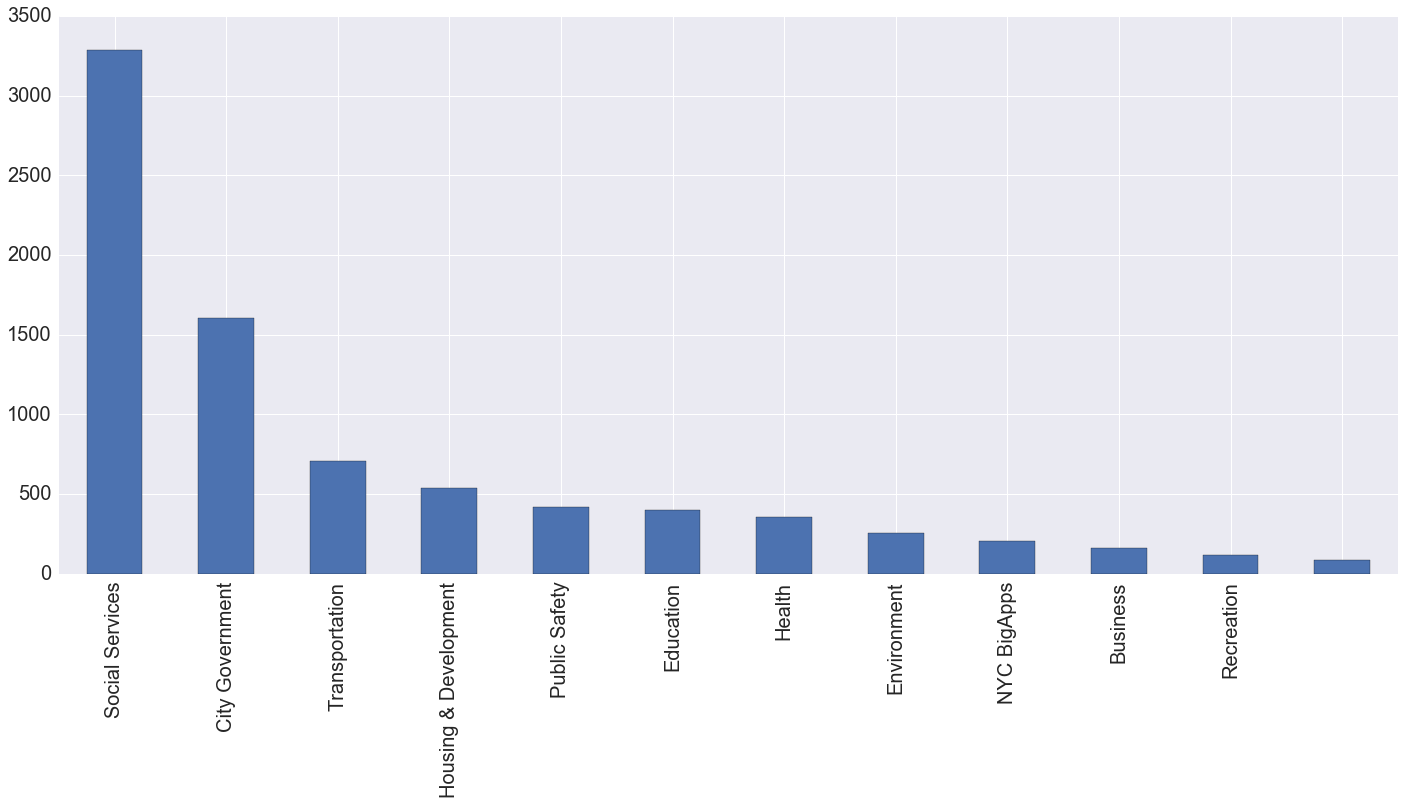

In [15]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Datasets**

In [117]:
endpoint_categories(datasets).value_counts()

City Government          365
Education                248
Housing & Development    165
Public Safety            158
Transportation           116
Social Services          113
Environment               90
Recreation                70
Business                  55
NYC BigApps               54
Health                    29
                          23
dtype: int64

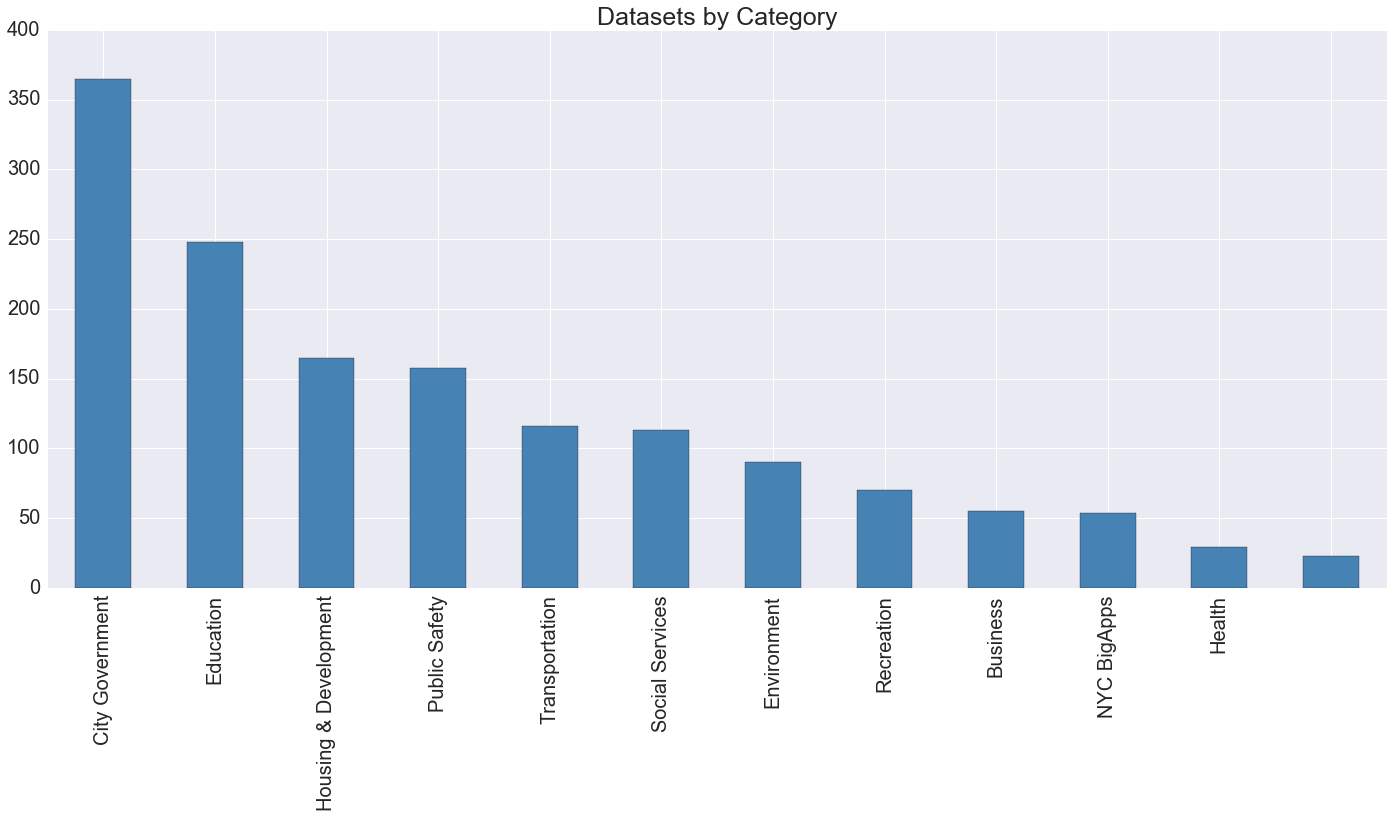

In [118]:
fig = plt.figure(figsize=(24, 10))
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')
plt.title('Datasets by Category', fontsize=25)

**Tables**

In [18]:
endpoint_categories(tabular_datasets).value_counts()

City Government          260
Education                224
Housing & Development    141
Public Safety            130
Social Services           88
Environment               61
Transportation            49
Business                  42
Recreation                31
Health                    23
                          17
NYC BigApps                7
dtype: int64

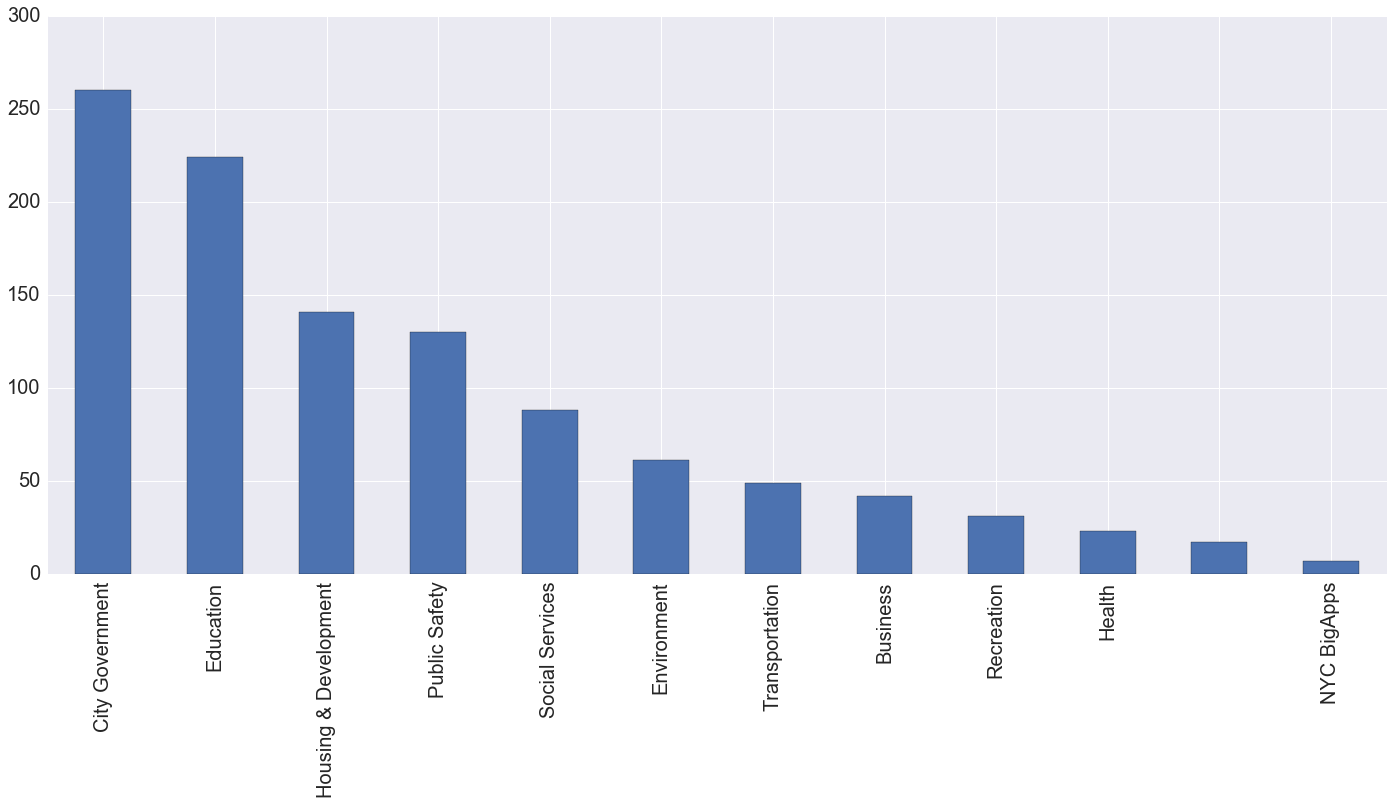

In [19]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Reliability**

These counts are known to be reliable insofar as simple categorization is reliable.

### Update Automation

In [20]:
pd.Series({2: 'Yes', 1: None})

1    None
2     Yes
dtype: object

In [21]:
def endpoint_automations(endpoints):
    """
    Returns a pd.Series mapping endpoints to their automation type.
    """
    def get_update_automation_type(endpoint):
        # Get the "domain metadata".
        domain_metadata = endpoint['classification']['domain_metadata']
        # Format example:
        # [{'key': 'Update_Automation', 'value': 'Yes'},
        #  {'key': 'Update_Update-Frequency', 'value': 'Daily'},
        #  {'key': 'Dataset-Information_Agency', 'value': 'Department of Buildings (DOB)'}]
        #
        # If Update_Automation is included it should be *first* entry.
        # But we don't want to just check for that! Because this could change in the future.
        # Instead we need to implement a search strategy.
        # First get all_keys.
        all_keys = [d['key'] for d in domain_metadata]
        # Then try to get the index. This raises a ValueError if it doesn't find anything---return None in that case.
        try:
            # If we didn't fail and return None, pick and return it.
            return domain_metadata[all_keys.index("Update_Automation")]['value']
        except ValueError:
            return None

    return pd.Series(map(get_update_automation_type, endpoints))

**Endpoints**

In [22]:
endpoint_automations(endpoints).value_counts(dropna=False)

NaN    6826
Yes     931
No      388
dtype: int64

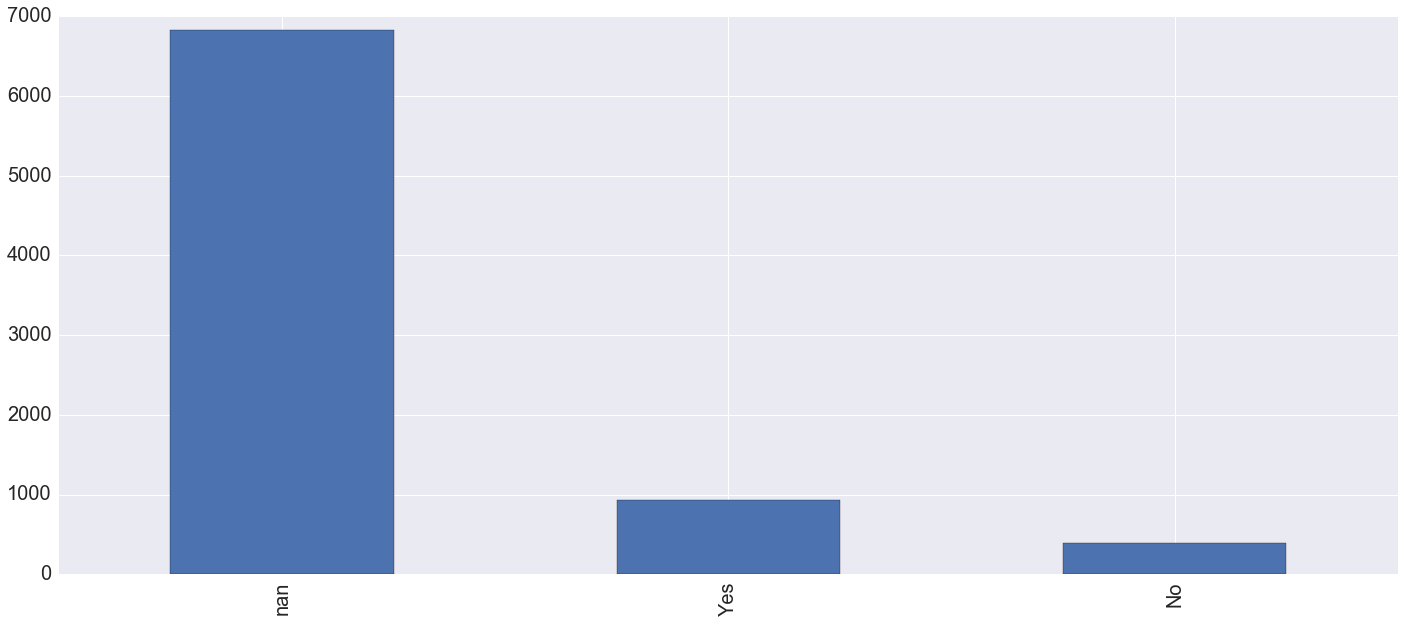

In [23]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Datasets**

In [115]:
endpoint_automations(datasets).value_counts(dropna=False)

NaN    1137
No      223
Yes     126
dtype: int64

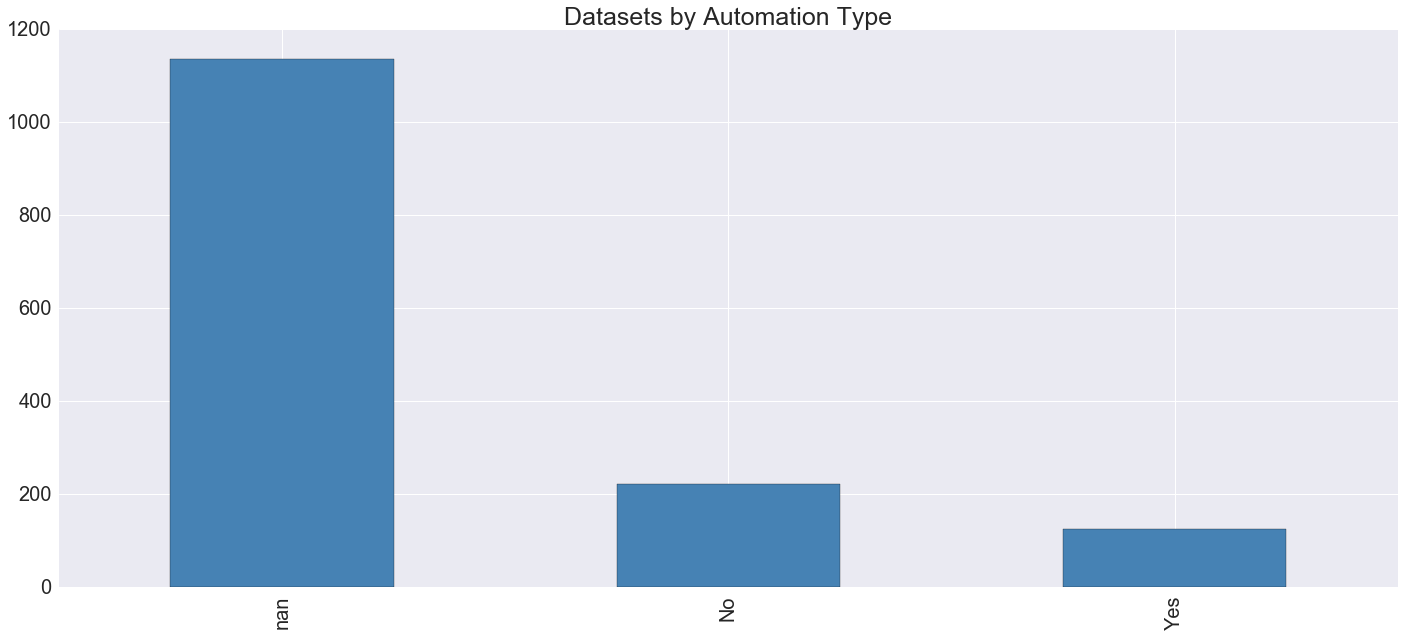

In [116]:
fig = plt.figure(figsize=(24, 10))
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')
plt.title('Datasets by Automation Type', fontsize=25)

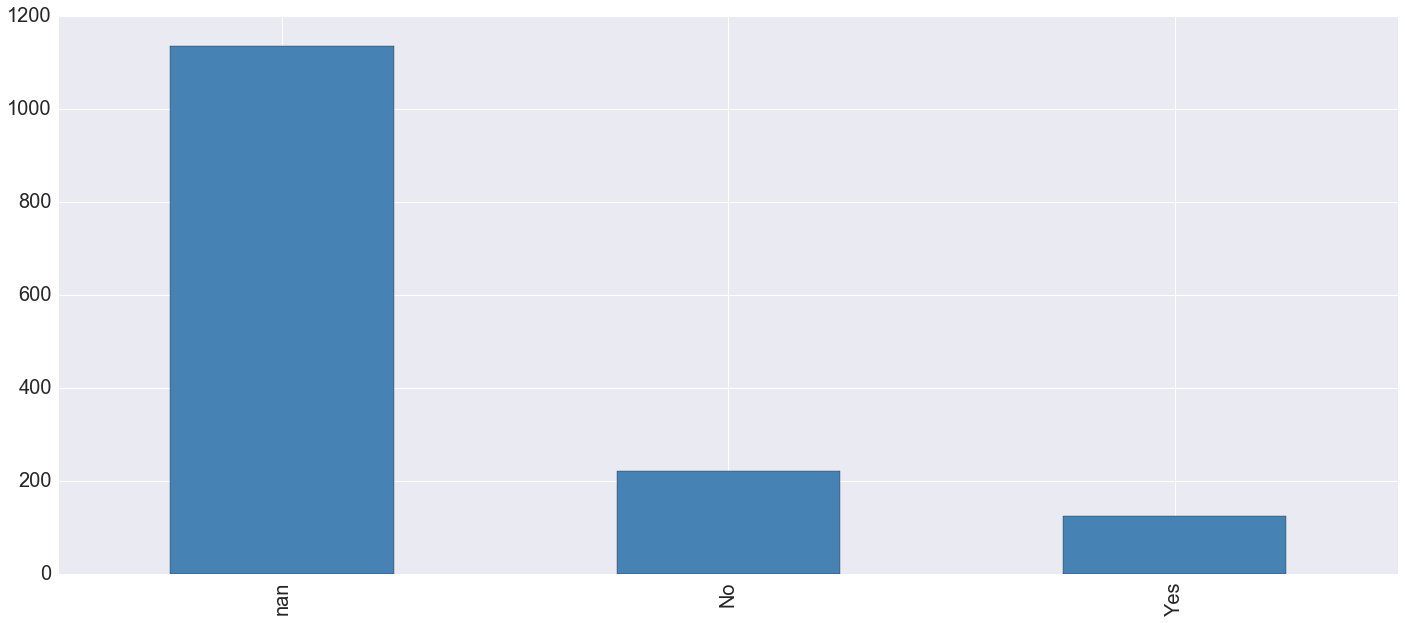

In [25]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')

**Tables**

In [26]:
endpoint_automations(tabular_datasets).value_counts(dropna=False)

NaN    796
No     153
Yes    124
dtype: int64

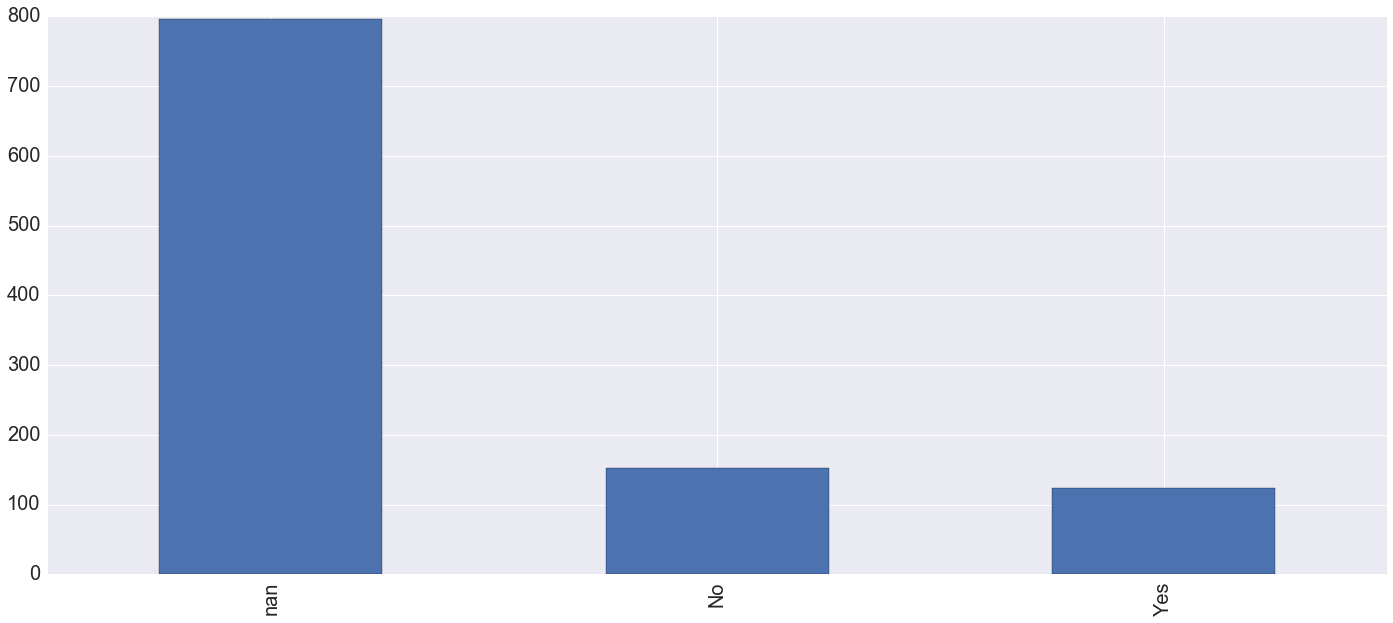

In [27]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

### Update Frequency

In [28]:
def endpoint_update_frequency(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update frequencies.
    """
    def get_update_frequency(endpoint):
        # Get the "domain metadata".
        domain_metadata = endpoint['classification']['domain_metadata']
        # Format example:
        # [{'key': 'Update_Automation', 'value': 'Yes'},
        #  {'key': 'Update_Update-Frequency', 'value': 'Daily'},
        #  {'key': 'Dataset-Information_Agency', 'value': 'Department of Buildings (DOB)'}]
        #
        # First get all_keys.
        all_keys = [d['key'] for d in domain_metadata]
        # Then try to get the index. This raises a ValueError if it doesn't find anything---return None in that case.
        try:
            # If we didn't fail and return None, pick and return it.
            return domain_metadata[all_keys.index("Update_Update-Frequency")]['value']
        except ValueError:
            # Otherwise throw out a None.
            return None

    return pd.Series(list(map(get_update_frequency, endpoints)))

**Endpoints**

In [29]:
endpoint_update_frequency(endpoints).value_counts(dropna=False)

Daily                       4564
As needed                   1273
Annually                     550
Monthly                      464
Historical Data              426
Weekdays                     332
NaN                          262
Weekly                        76
Quarterly                     68
Biannually                    53
Several times per minute      44
Biweekly                      16
2 to 4 times per year          7
Bimonthly                      4
                               3
Unknown                        2
Annually                       1
dtype: int64

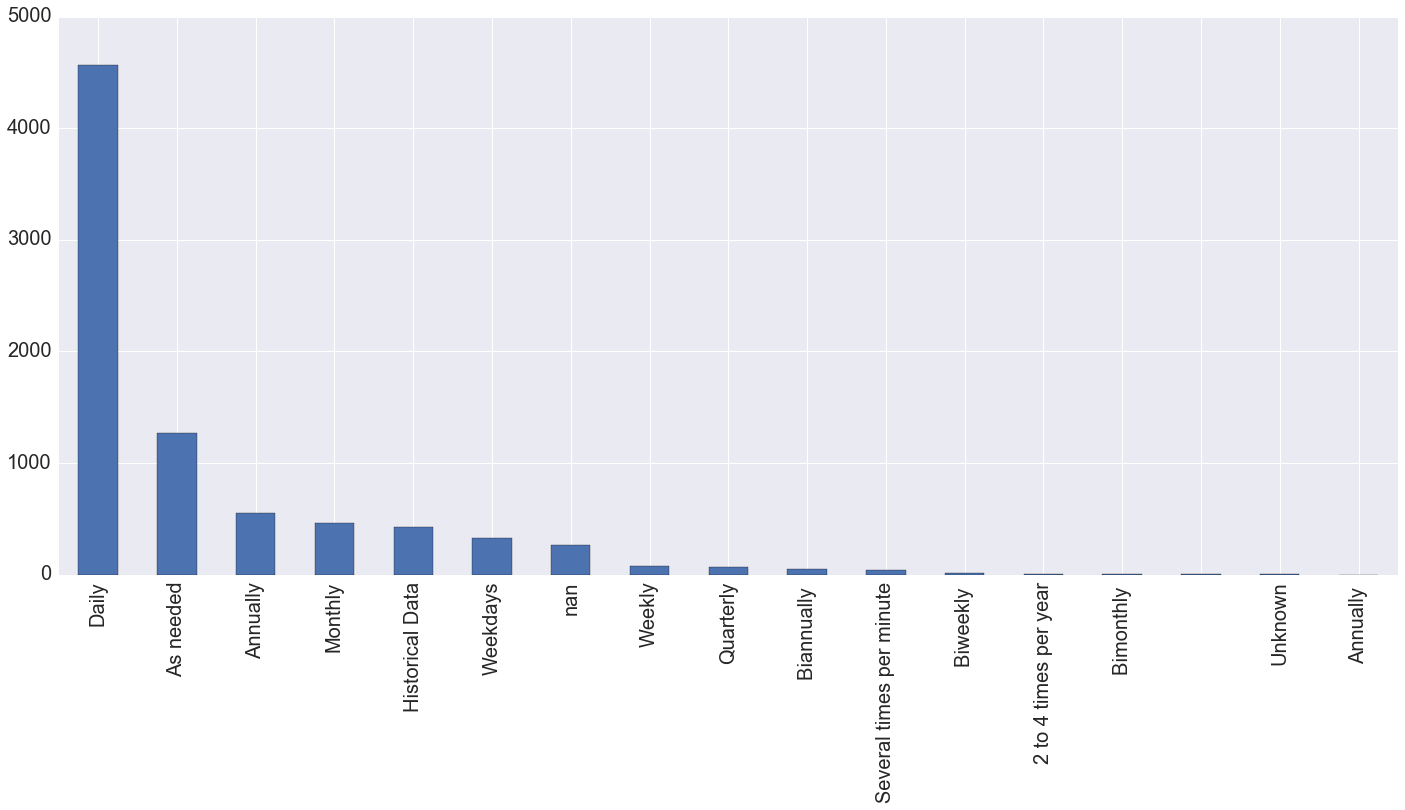

In [30]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

**Datasets**

In [122]:
endpoint_update_frequency(datasets).value_counts(dropna=False)

As needed                   536
Annually                    365
Historical Data             169
NaN                         158
Monthly                      79
Daily                        73
Biannually                   32
Weekly                       31
Quarterly                    27
Weekdays                      4
Bimonthly                     3
                              3
Biweekly                      2
Several times per minute      1
Annually                      1
2 to 4 times per year         1
Unknown                       1
dtype: int64

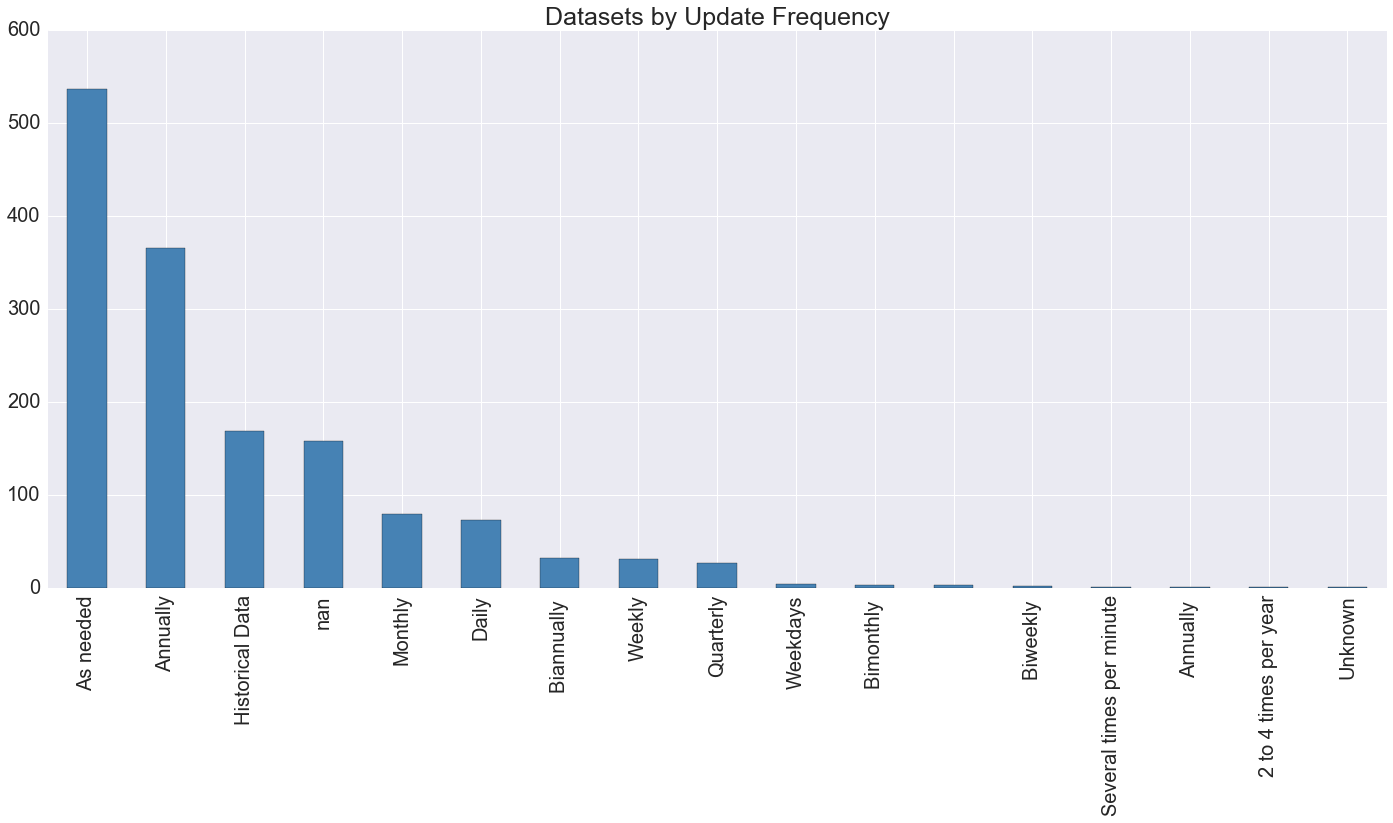

In [123]:
fig = plt.figure(figsize=(24, 10))
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')
plt.title('Datasets by Update Frequency', fontsize=25)

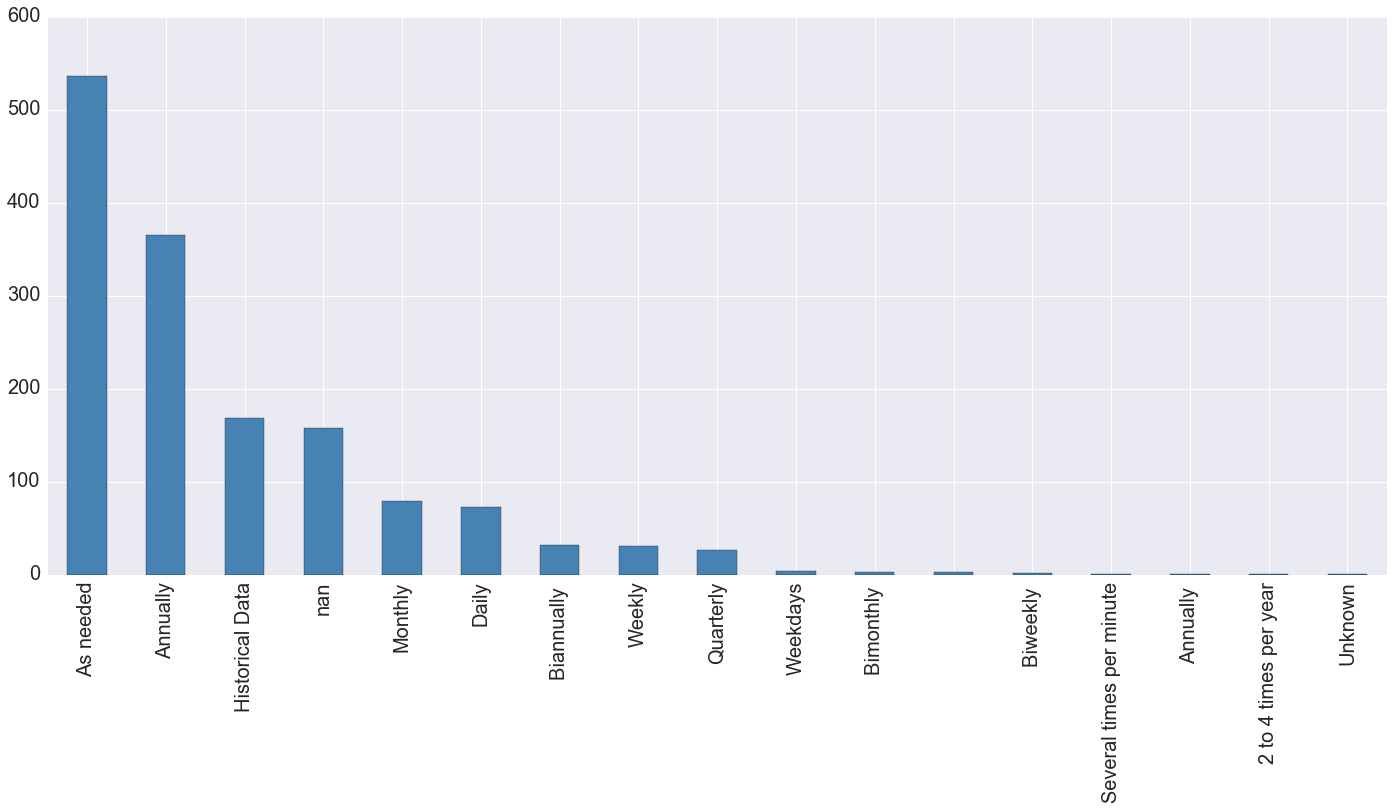

In [32]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20, color='steelblue')

**Tables**

In [33]:
endpoint_update_frequency(tabular_datasets).value_counts(dropna=False)

Annually                    333
As needed                   235
NaN                         149
Historical Data             138
Monthly                      76
Daily                        47
Biannually                   30
Weekly                       29
Quarterly                    22
Weekdays                      4
Bimonthly                     3
                              3
Unknown                       1
Annually                      1
Several times per minute      1
Biweekly                      1
dtype: int64

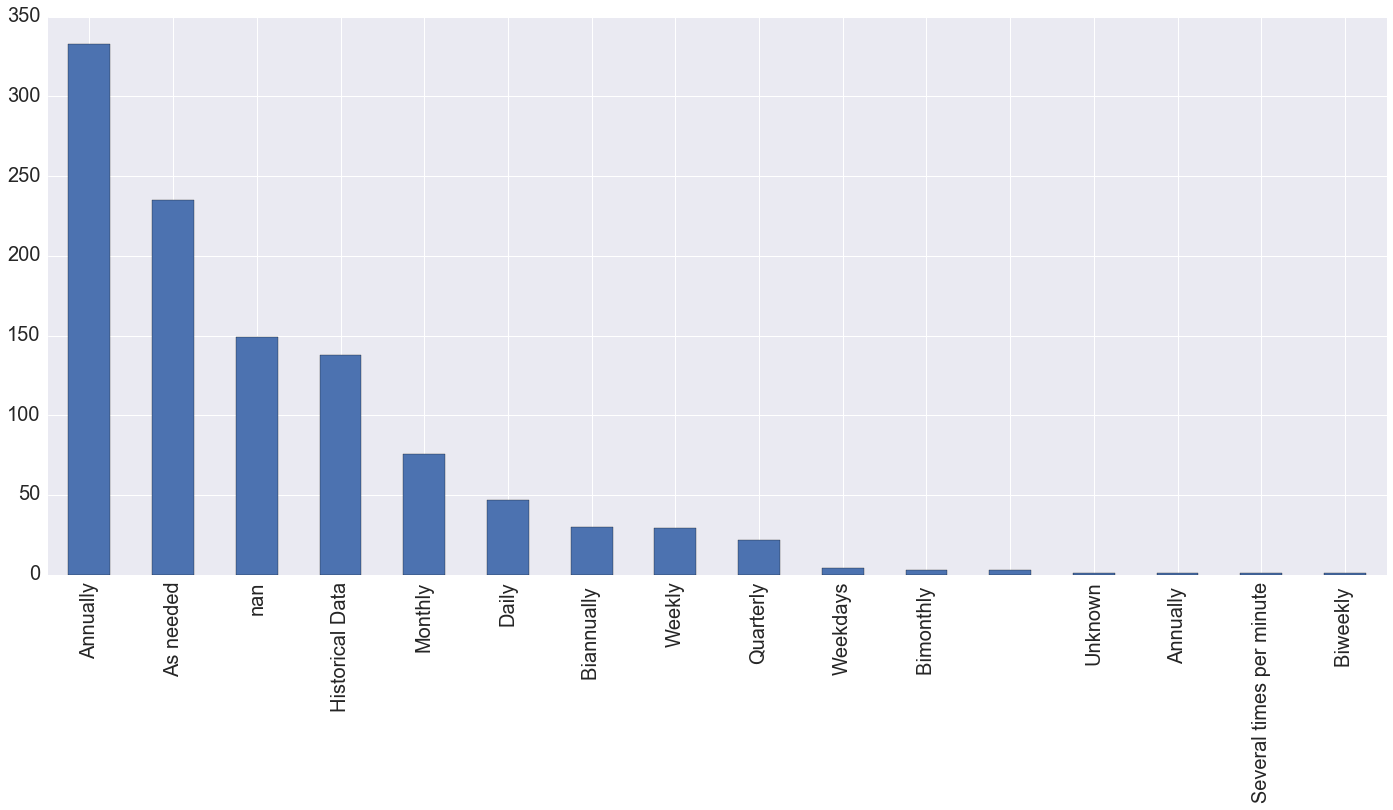

In [34]:
_.plot(kind='bar', figsize=(24, 10), fontsize=20)

What's that one updated several times per minute?

In [35]:
tabular_hashes = pd.Series([d['permalink'].split("/")[-1] for d in tabular_datasets])

tabular_hashes[endpoint_update_frequency(tabular_datasets) == 'Several times per minute']

29    tdsx-cvye
dtype: object

Oh. Go figure.

### Dataset Ownership

Note: this uses `information_agency` under `domain_metadata`. There's also `resource_attribution` under `resource`, but that seems to be a lot less clean&mdash;doing things like substiting `NYPD` for `New York Police Department (NYPD)`, for example. Though I believe technically these fields are a little different&mdash;one is who *provided* the dataset, one is who *made* it&mdash;but I think it makes little real difference one way or the other.

In [36]:
def endpoint_ownership(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update frequencies.
    """
    def get_endpoint_owner(endpoint):
        # Get the "domain metadata".
        domain_metadata = endpoint['classification']['domain_metadata']
        # Format example:
        # [{'key': 'Update_Automation', 'value': 'Yes'},
        #  {'key': 'Update_Update-Frequency', 'value': 'Daily'},
        #  {'key': 'Dataset-Information_Agency', 'value': 'Department of Buildings (DOB)'}]
        #
        # First get all_keys.
        all_keys = [d['key'] for d in domain_metadata]
        # Then try to get the index. This raises a ValueError if it doesn't find anything---return None in that case.
        try:
            # If we didn't fail and return None, pick and return it.
            return domain_metadata[all_keys.index("Dataset-Information_Agency")]['value']
        except ValueError:
            # Otherwise throw out a None.
            return None

    return pd.Series(list(map(get_endpoint_owner, endpoints)))

**Endpoints**

In [37]:
endpoint_ownership(endpoints).value_counts(dropna=False)

311                                                                    3096
Taxi and Limousine Commission (TLC)                                     497
Office of Administrative Trials and Hearings (OATH)                     495
Department of Finance (DOF)                                             446
Police Department (NYPD)                                                358
Department of Health and Mental Hygiene (DOHMH)                         337
Department of Education (DOE)                                           318
Department of City Planning (DCP)                                       231
Department of Citywide Administrative Services (DCAS)                   223
Department of Buildings (DOB)                                           202
Department of Information Technology & Telecommunications (DoITT)       180
Metropolitan Transportation Authority (MTA)                             169
Department of Parks and Recreation (DPR)                                134
Civilian Com

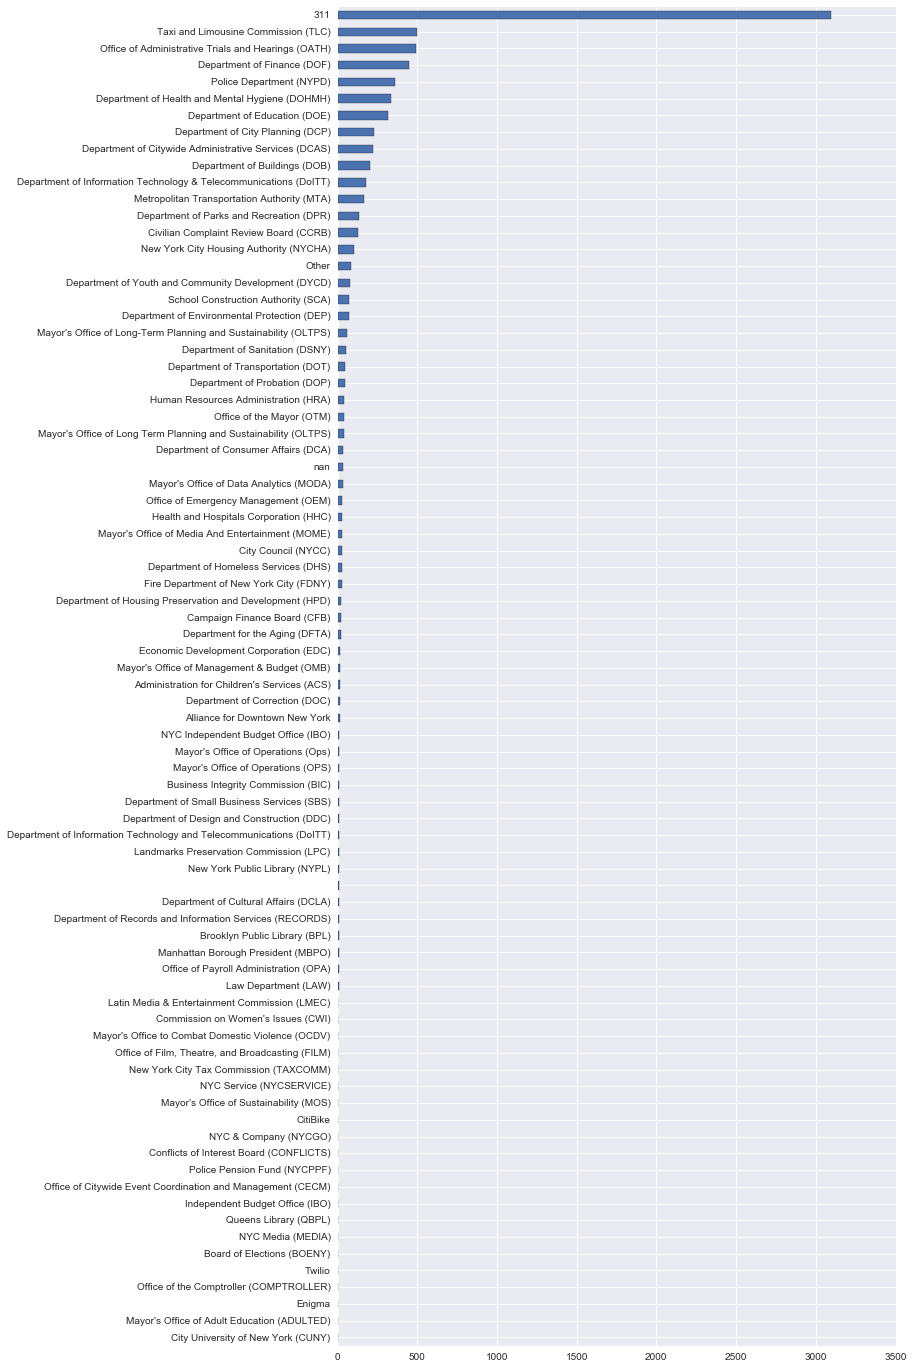

In [38]:
_.sort_values(ascending=True).plot(kind='barh', figsize=(10, 24))

**Datasets**

In [111]:
endpoint_ownership(datasets).value_counts(dropna=False)

Department of Education (DOE)                                        203
Civilian Complaint Review Board (CCRB)                               118
Department of City Planning (DCP)                                    104
Department of Finance (DOF)                                           80
Department of Information Technology & Telecommunications (DoITT)     75
Department of Parks and Recreation (DPR)                              67
Taxi and Limousine Commission (TLC)                                   66
Other                                                                 64
Department of Environmental Protection (DEP)                          45
School Construction Authority (SCA)                                   44
Department of Youth and Community Development (DYCD)                  42
Department of Probation (DOP)                                         40
Human Resources Administration (HRA)                                  36
Office of the Mayor (OTM)                          

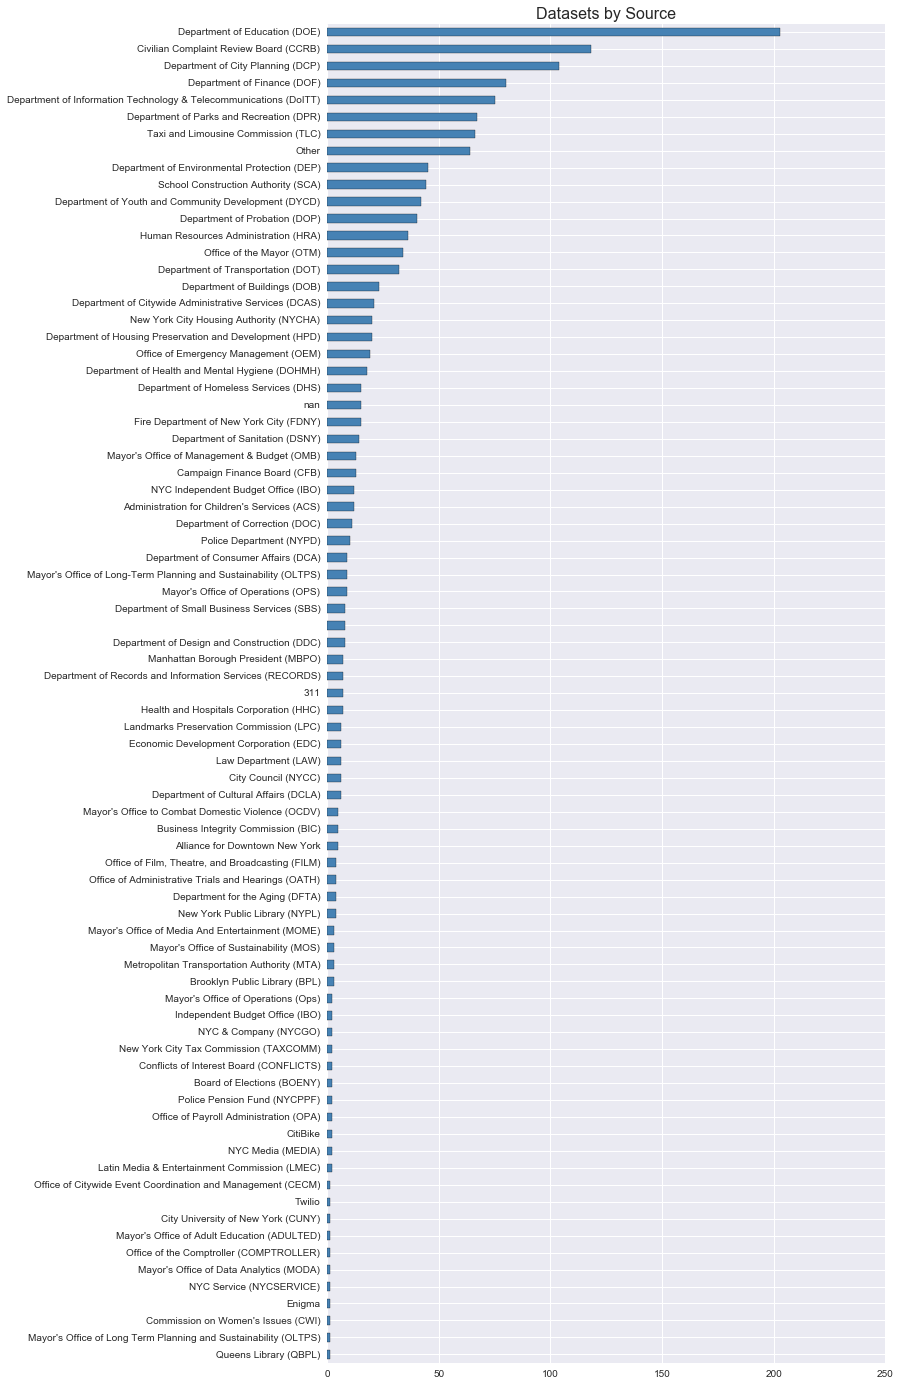

In [112]:
fig = plt.figure(figsize=(24, 10))
_.sort_values(ascending=True).plot(kind='barh', figsize=(10, 24), color='steelblue')
plt.title('Datasets by Source', fontsize=16)

**Tables**

In [41]:
endpoint_ownership(tabular_datasets).value_counts(dropna=False)

Department of Education (DOE)                                        179
Civilian Complaint Review Board (CCRB)                               119
Department of Finance (DOF)                                           69
School Construction Authority (SCA)                                   44
Taxi and Limousine Commission (TLC)                                   40
Department of Environmental Protection (DEP)                          40
Department of Probation (DOP)                                         40
Department of Youth and Community Development (DYCD)                  36
Human Resources Administration (HRA)                                  36
Department of City Planning (DCP)                                     31
Office of the Mayor (OTM)                                             23
Department of Buildings (DOB)                                         23
New York City Housing Authority (NYCHA)                               22
Department of Information Technology & Telecommunic

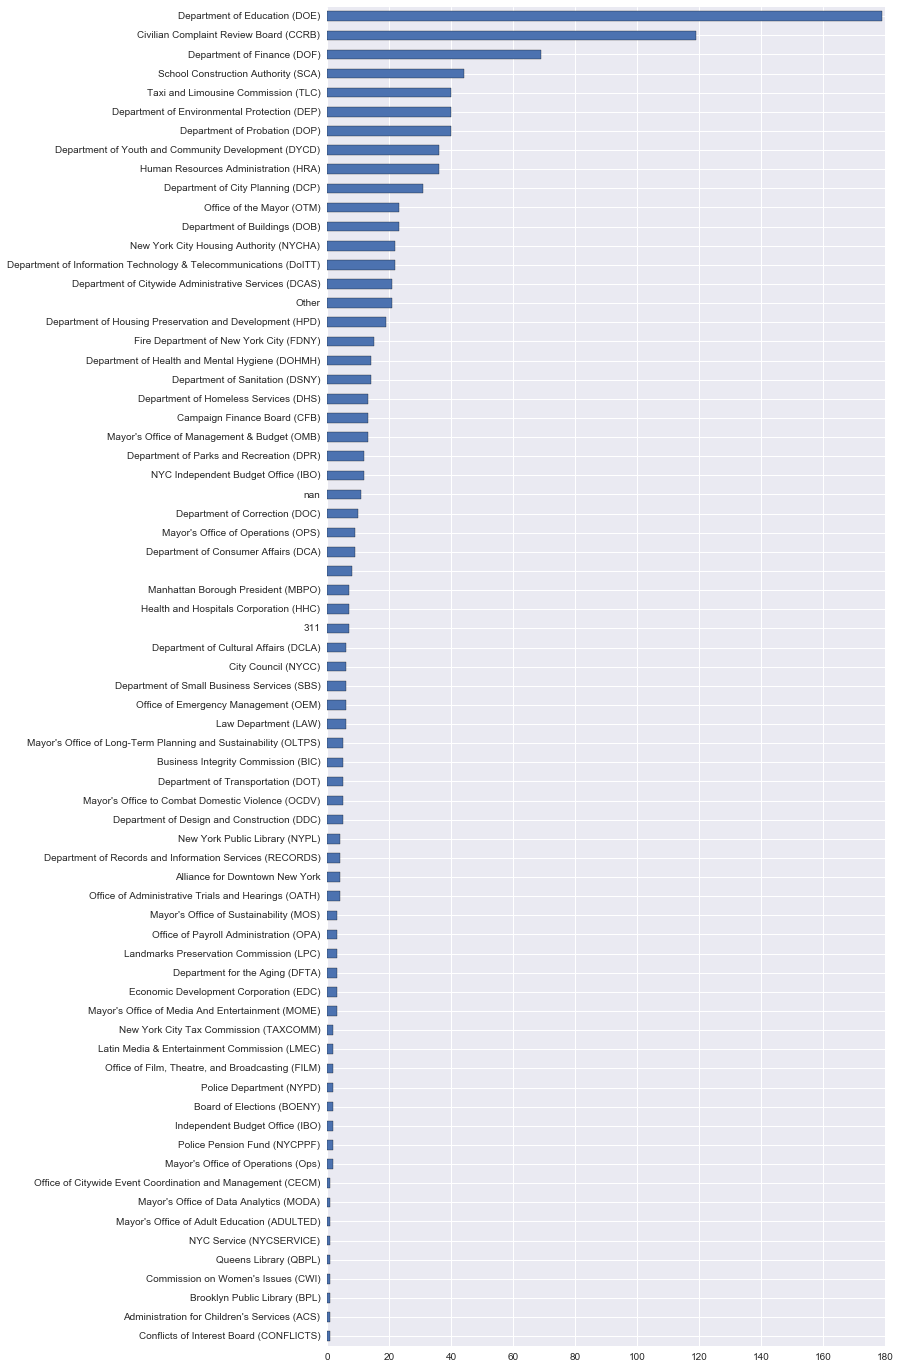

In [42]:
_.sort_values(ascending=True).plot(kind='barh', figsize=(10, 24))

### Creation Date


In [43]:
def endpoint_creation_dates(endpoints):
    """
    Returns a pd.Series mapping endpoints to their creation times.
    """
    return pd.to_datetime(pd.Series(list(map(lambda d: d['resource']['createdAt'], endpoints))))

**Endpoints**

What is the first-ever endpoint?

In [44]:
endpoint_creation_dates(endpoints).sort_values().head(5)

237   2010-11-03 17:15:45
40    2011-07-26 16:26:28
87    2011-07-26 19:48:24
86    2011-07-26 19:56:27
962   2011-07-26 19:59:04
dtype: datetime64[ns]

In [45]:
endpoints[endpoint_creation_dates(endpoints).sort_values().index[0]]['resource']['id']

'xszr-btpb'

> Electronics Stores
>
> A list of electronics stores that have a current DCA license as of the run date.

Well that's weird. The time lag between the first entry and the last one is also very strange.

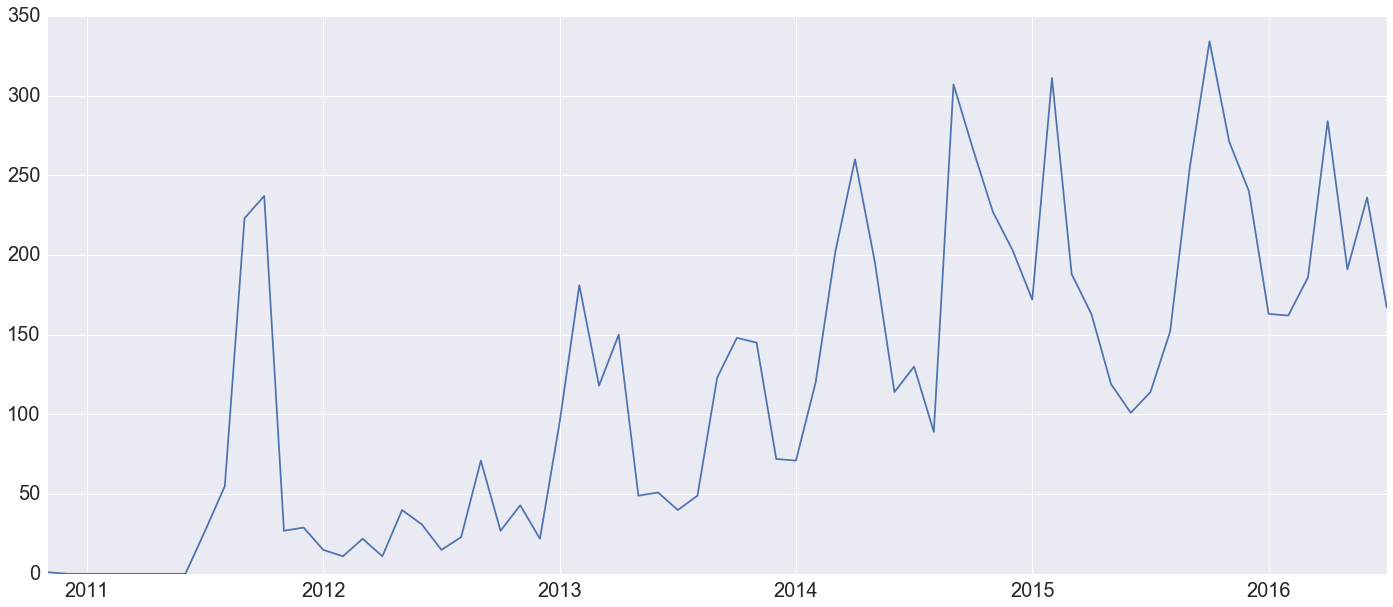

In [46]:
# Monthly endpoint creation
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('M').count().plot(figsize=(24, 10),
                                                                                                             fontsize=20)

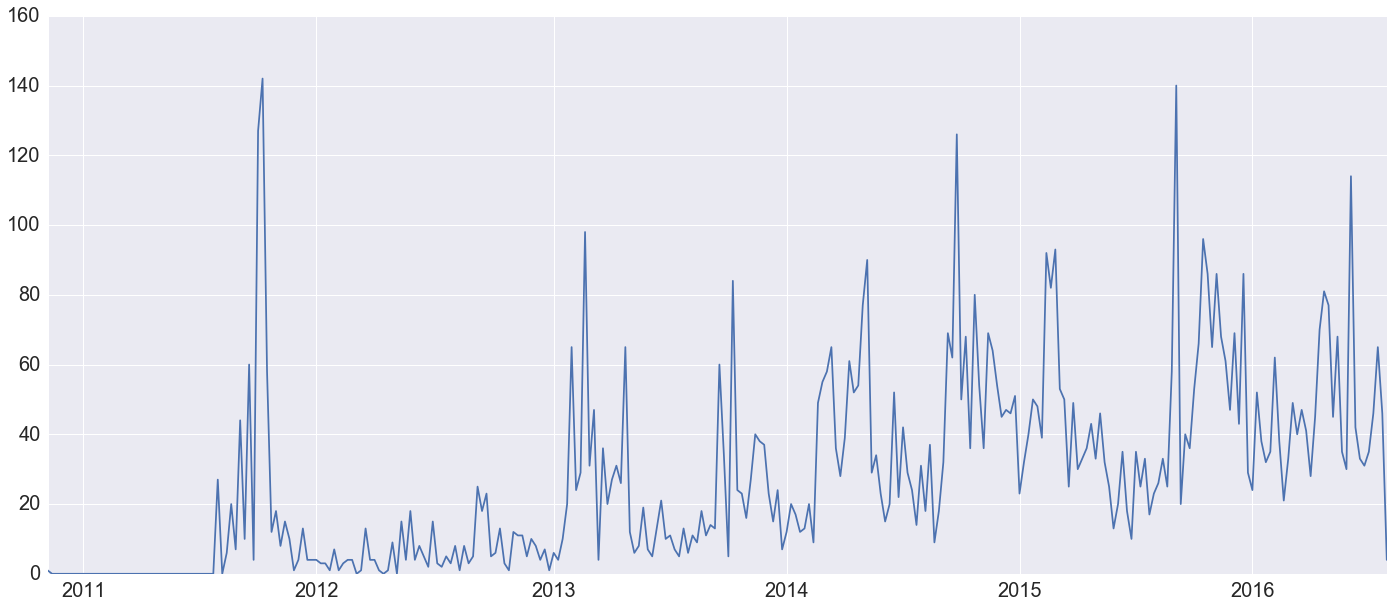

In [47]:
# Weekly endpoint creation
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W').count().plot(figsize=(24, 10),
                                                                                                             fontsize=20)

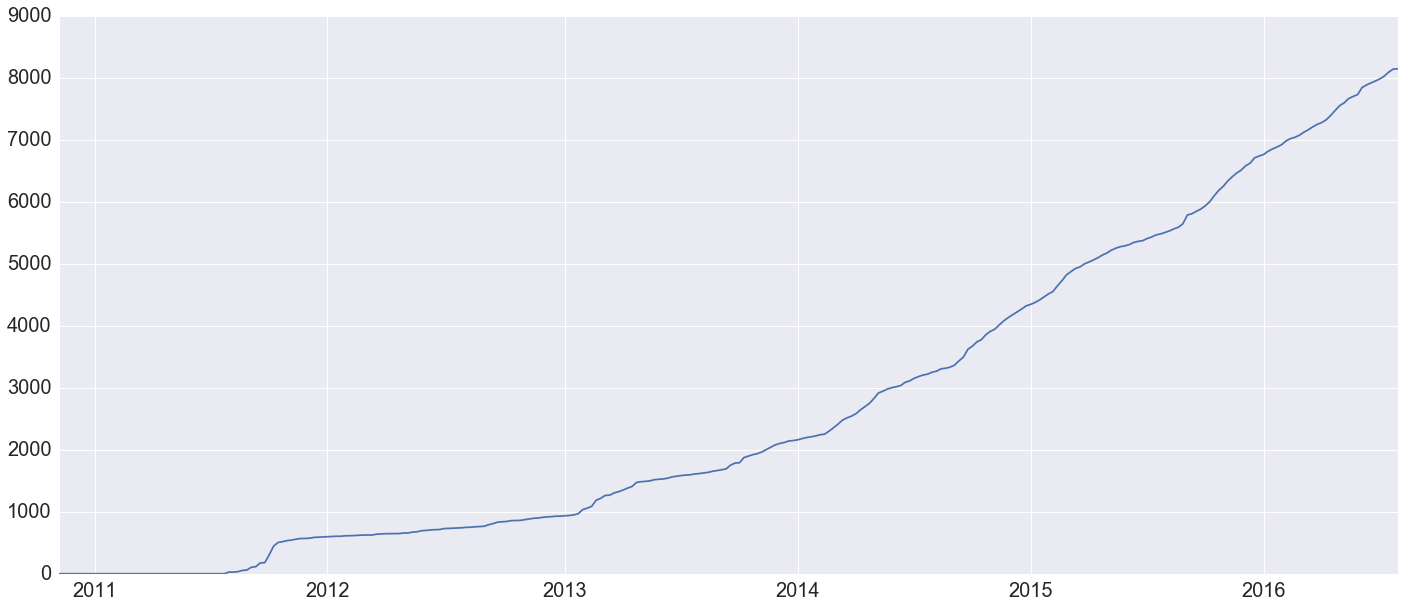

In [48]:
# Cumulative endpoint count.
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

In [49]:
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W')

C:\Users\Alex\Anaconda3\lib\site-packages\IPython\lib\pretty.py:108: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  return getattr(obj, attr, default)


DatetimeIndexResampler [freq=<Week: weekday=6>, axis=0, closed=right, label=right, convention=start, base=0]

In [50]:
pd.Series(range(len(endpoints)), index=endpoint_creation_dates(endpoints).values).resample('W').count().cumsum()

2010-11-07       1
2010-11-14       1
2010-11-21       1
2010-11-28       1
2010-12-05       1
2010-12-12       1
2010-12-19       1
2010-12-26       1
2011-01-02       1
2011-01-09       1
2011-01-16       1
2011-01-23       1
2011-01-30       1
2011-02-06       1
2011-02-13       1
2011-02-20       1
2011-02-27       1
2011-03-06       1
2011-03-13       1
2011-03-20       1
2011-03-27       1
2011-04-03       1
2011-04-10       1
2011-04-17       1
2011-04-24       1
2011-05-01       1
2011-05-08       1
2011-05-15       1
2011-05-22       1
2011-05-29       1
              ... 
2016-01-10    6814
2016-01-17    6852
2016-01-24    6884
2016-01-31    6919
2016-02-07    6981
2016-02-14    7019
2016-02-21    7040
2016-02-28    7073
2016-03-06    7122
2016-03-13    7162
2016-03-20    7209
2016-03-27    7250
2016-04-03    7278
2016-04-10    7323
2016-04-17    7393
2016-04-24    7474
2016-05-01    7551
2016-05-08    7596
2016-05-15    7664
2016-05-22    7699
2016-05-29    7729
2016-06-05  

**Datasets**

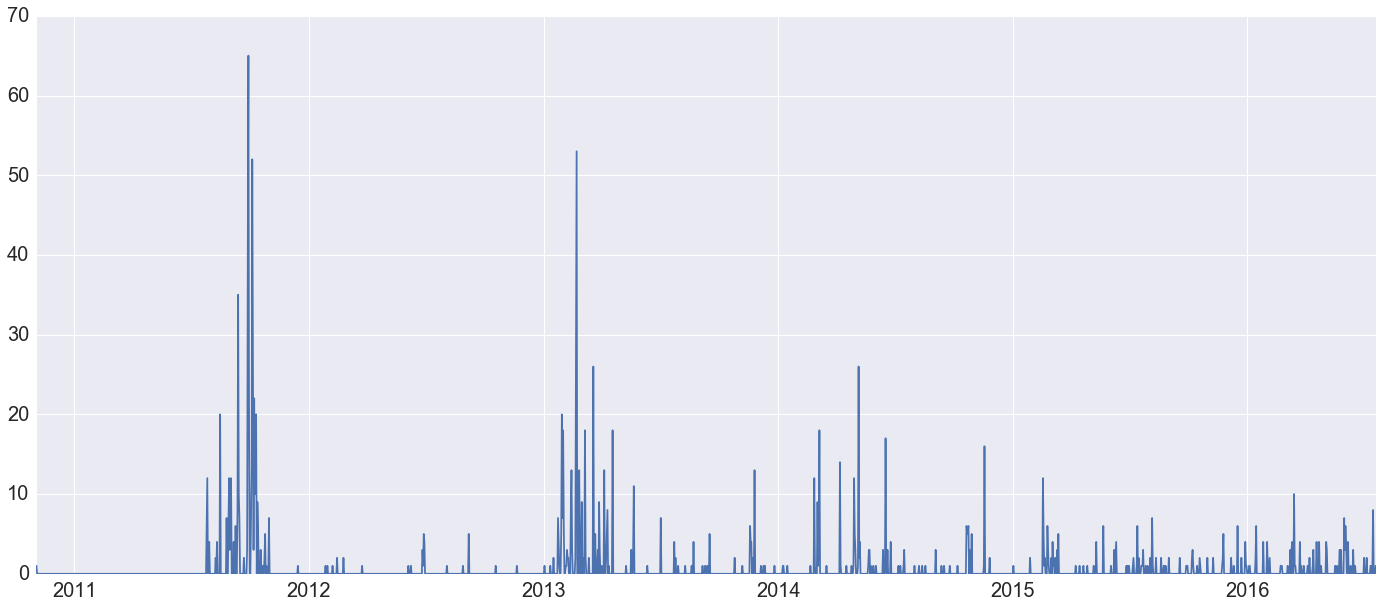

In [127]:
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('D').count().plot(figsize=(24, 10),
                                                                                                             fontsize=20)

In [130]:
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('D').count().sort_values(ascending=False)

2011-09-29    65
2013-02-21    53
2011-10-05    52
2011-09-28    40
2011-09-13    35
2013-02-20    28
2013-03-19    26
2011-10-06    26
2014-05-06    26
2011-10-08    22
2013-01-29    20
2011-10-11    20
2011-08-16    20
2011-09-30    19
2011-10-10    18
2014-03-06    18
2013-04-18    18
2013-01-31    18
2013-03-06    18
2014-06-17    17
2014-11-18    16
2014-04-07    14
2013-04-05    13
2013-11-25    13
2013-02-25    13
2011-10-04    13
2013-02-13    13
2011-09-02    12
2014-02-26    12
2014-04-29    12
              ..
2016-02-08     0
2016-02-07     0
2014-02-03     0
2014-02-02     0
2014-02-01     0
2014-01-31     0
2016-02-12     0
2016-02-11     0
2014-01-10     0
2014-01-11     0
2014-01-12     0
2014-01-13     0
2014-01-14     0
2016-02-10     0
2014-01-16     0
2014-01-17     0
2014-01-18     0
2014-01-19     0
2014-01-20     0
2014-01-21     0
2014-01-22     0
2014-01-23     0
2014-01-24     0
2014-01-25     0
2014-01-26     0
2014-01-27     0
2014-01-28     0
2014-01-29    

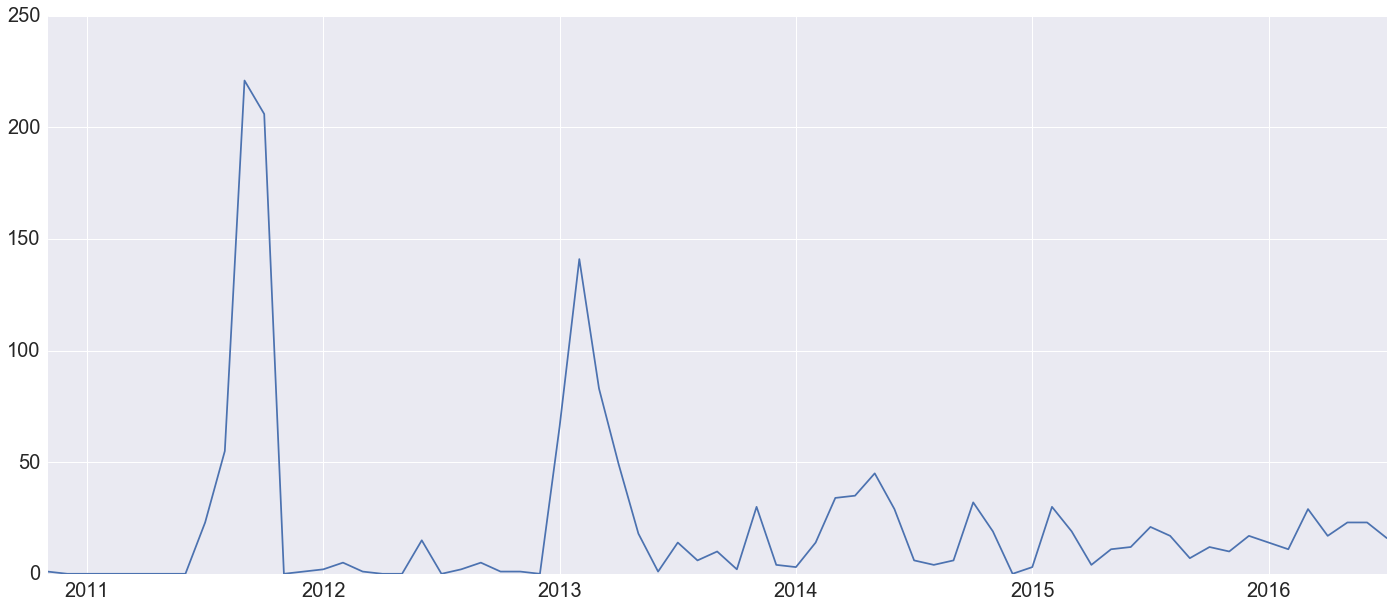

In [51]:
# Monthly dataset creation
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('M').count().plot(figsize=(24, 10), fontsize=20)

The trend is moderately upwards, but the graph as a whole is dominated by a couple of really big publication dates:

In [52]:
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('M').count().sort_values(ascending=False)

2011-09-30    221
2011-10-31    206
2013-02-28    141
2013-03-31     83
2013-01-31     66
2011-08-31     55
2013-04-30     49
2014-05-31     45
2014-04-30     35
2014-03-31     34
2014-10-31     32
2015-02-28     30
2013-11-30     30
2014-06-30     29
2016-03-31     29
2011-07-31     23
2016-06-30     23
2016-05-31     23
2015-07-31     21
2015-03-31     19
2014-11-30     19
2013-05-31     18
2015-08-31     17
2015-12-31     17
2016-04-30     17
2016-07-31     16
2012-06-30     15
2014-02-28     14
2016-01-31     14
2013-07-31     14
             ... 
2014-09-30      6
2012-09-30      5
2012-02-29      5
2013-12-31      4
2014-08-31      4
2015-04-30      4
2014-01-31      3
2015-01-31      3
2013-10-31      2
2012-08-31      2
2012-01-31      2
2011-12-31      1
2012-03-31      1
2013-06-30      1
2012-10-31      1
2012-11-30      1
2010-11-30      1
2011-11-30      0
2012-07-31      0
2014-12-31      0
2012-12-31      0
2012-05-31      0
2011-06-30      0
2011-05-31      0
2011-04-30

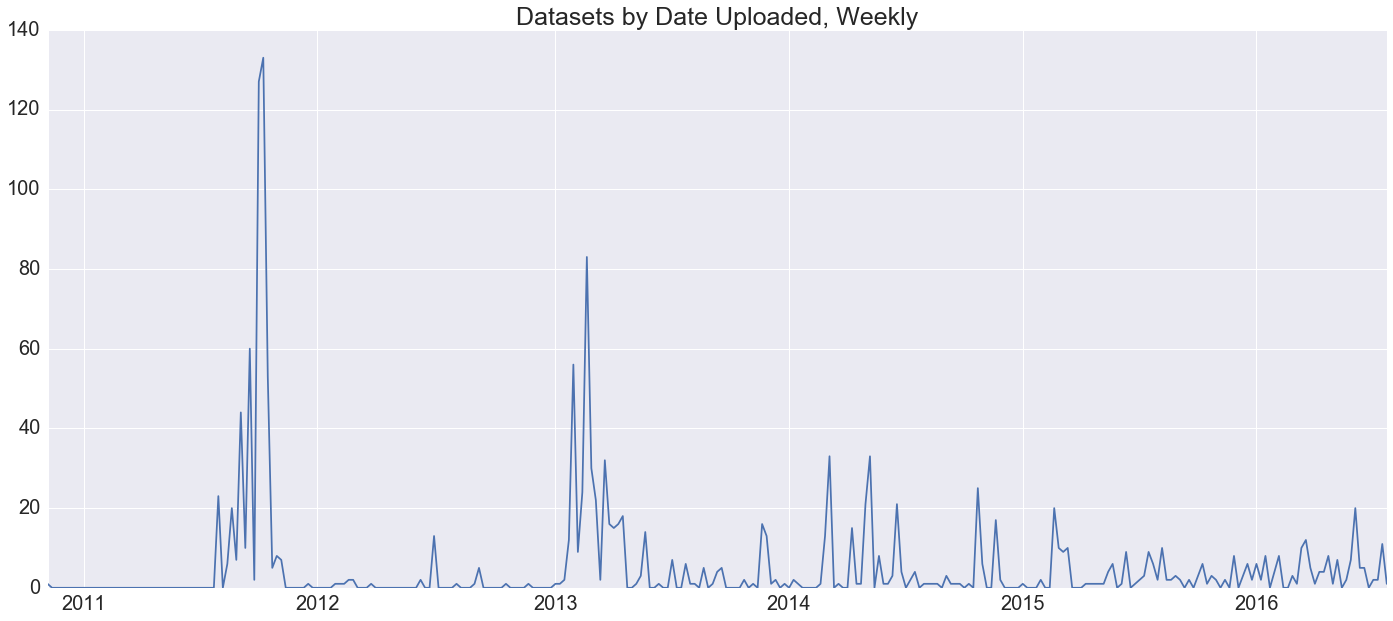

In [125]:
# Weekly dataset creation
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('W').count().plot(figsize=(24, 10), fontsize=20)
plt.title('Datasets by Date Uploaded, Weekly', fontsize=25)

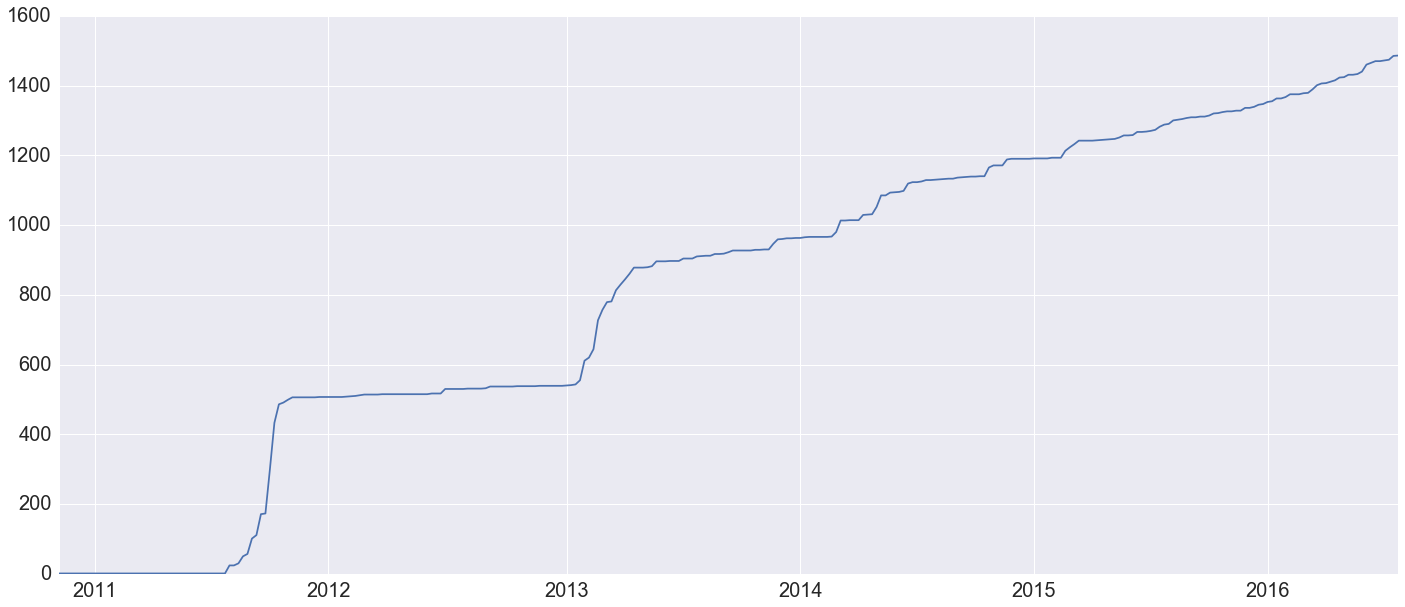

In [54]:
# Cumulative dataset count.
pd.Series(range(len(datasets)), index=endpoint_creation_dates(datasets).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

**Tables**

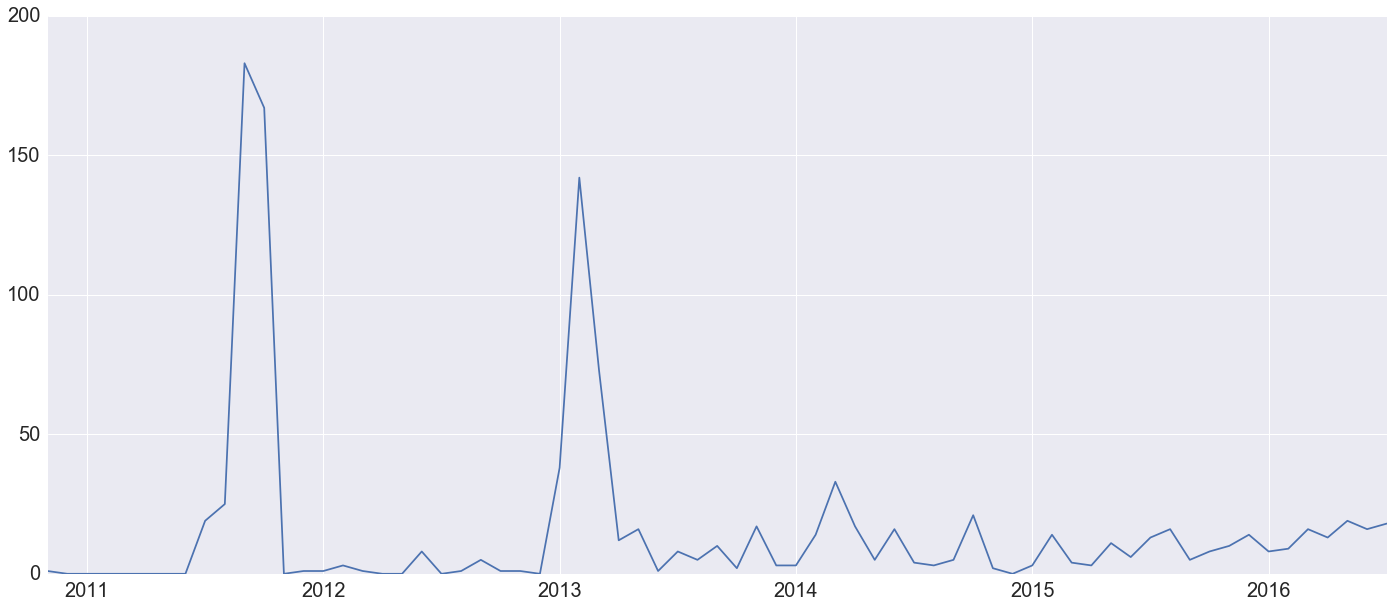

In [55]:
# Monthly tabular dataset creation
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('M').count().plot(figsize=(24, 10),
                                                                                                                           fontsize=20)

The trend is moderately upwards, but the graph as a whole is dominated by a couple of really big publication dates:

In [56]:
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('M').count().sort_values(ascending=False)

2011-09-30    183
2011-10-31    167
2013-02-28    142
2013-03-31     73
2013-01-31     38
2014-03-31     33
2011-08-31     25
2014-10-31     21
2016-05-31     19
2011-07-31     19
2016-07-31     18
2013-11-30     17
2014-04-30     17
2014-06-30     16
2015-08-31     16
2013-05-31     16
2016-06-30     16
2016-03-31     16
2015-02-28     14
2015-12-31     14
2014-02-28     14
2016-04-30     13
2015-07-31     13
2013-04-30     12
2015-05-31     11
2013-09-30     10
2015-11-30     10
2016-02-29      9
2012-06-30      8
2015-10-31      8
             ... 
2015-03-31      4
2015-01-31      3
2015-04-30      3
2013-12-31      3
2014-01-31      3
2014-08-31      3
2012-02-29      3
2013-10-31      2
2014-11-30      2
2012-03-31      1
2011-12-31      1
2012-01-31      1
2012-08-31      1
2010-11-30      1
2012-10-31      1
2012-11-30      1
2013-06-30      1
2011-05-31      0
2010-12-31      0
2011-01-31      0
2011-02-28      0
2011-03-31      0
2011-04-30      0
2012-04-30      0
2011-06-30

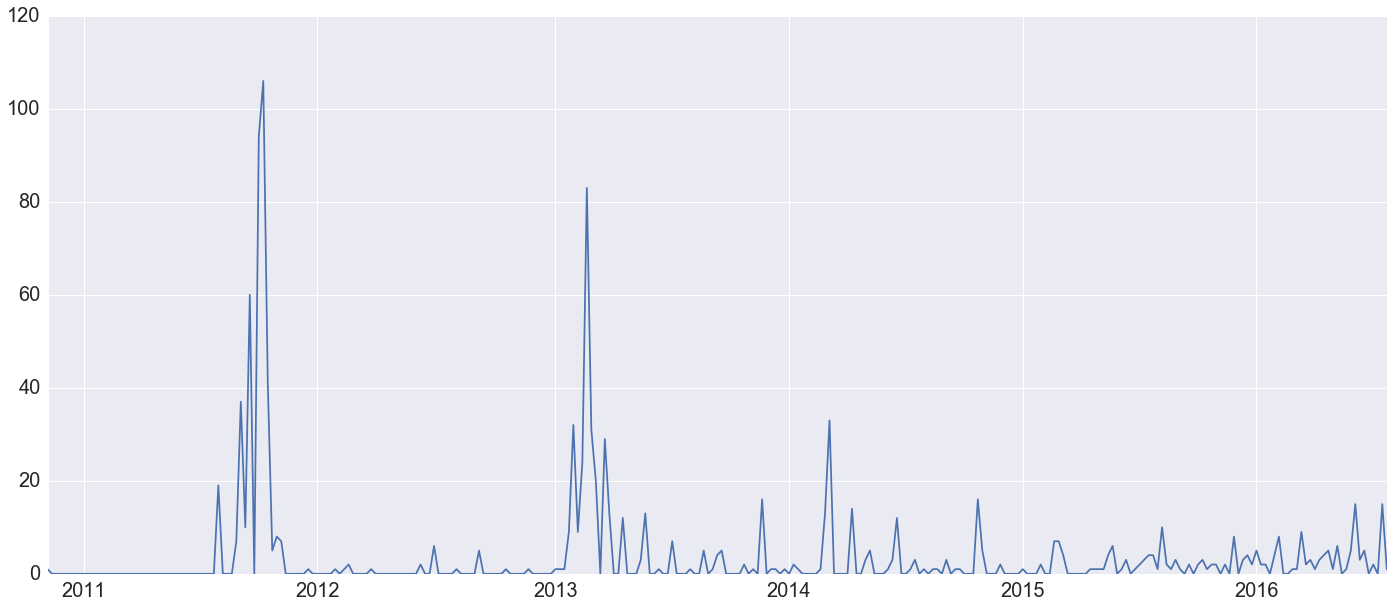

In [57]:
# Weekly endpoint creation
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('W').count().plot(figsize=(24, 10),
                                                                                                                           fontsize=20)

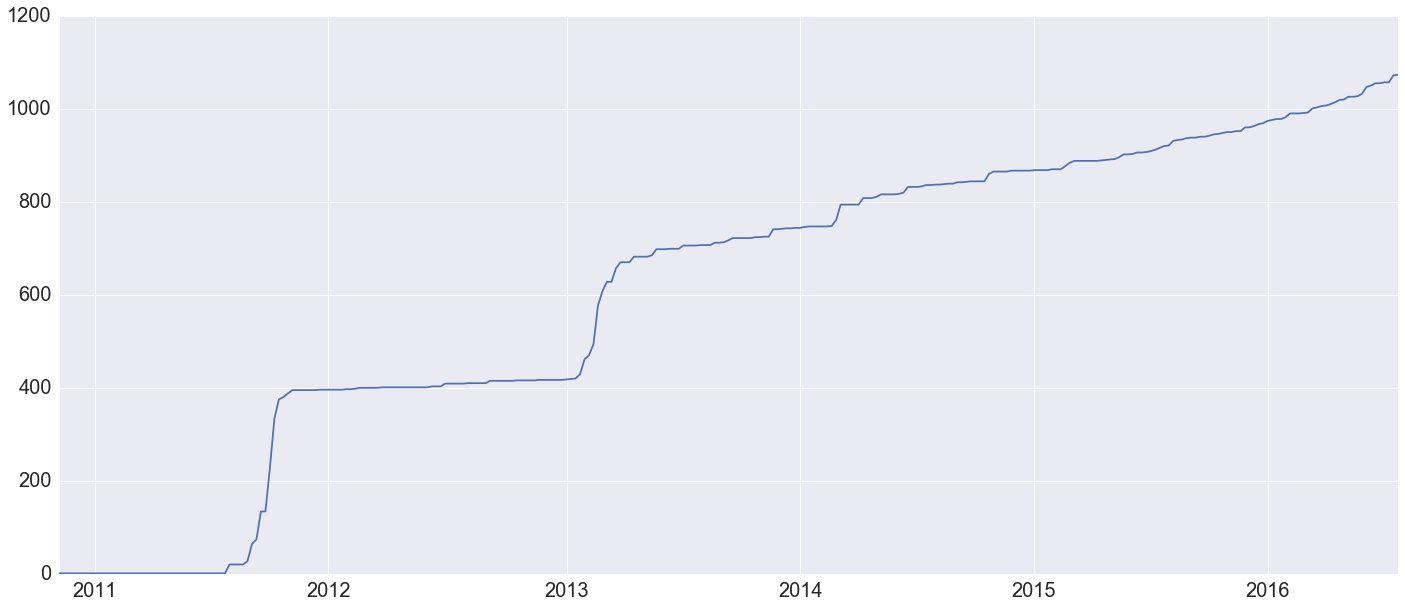

In [58]:
# Cumulative endpoint count.
pd.Series(range(len(tabular_datasets)), index=endpoint_creation_dates(tabular_datasets).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

### Updated-ness

In [59]:
def endpoint_update_dates(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update dates.
    """
    return pd.to_datetime(pd.Series(list(map(lambda d: d['resource']['updatedAt'], endpoints))))

**Endpoints**

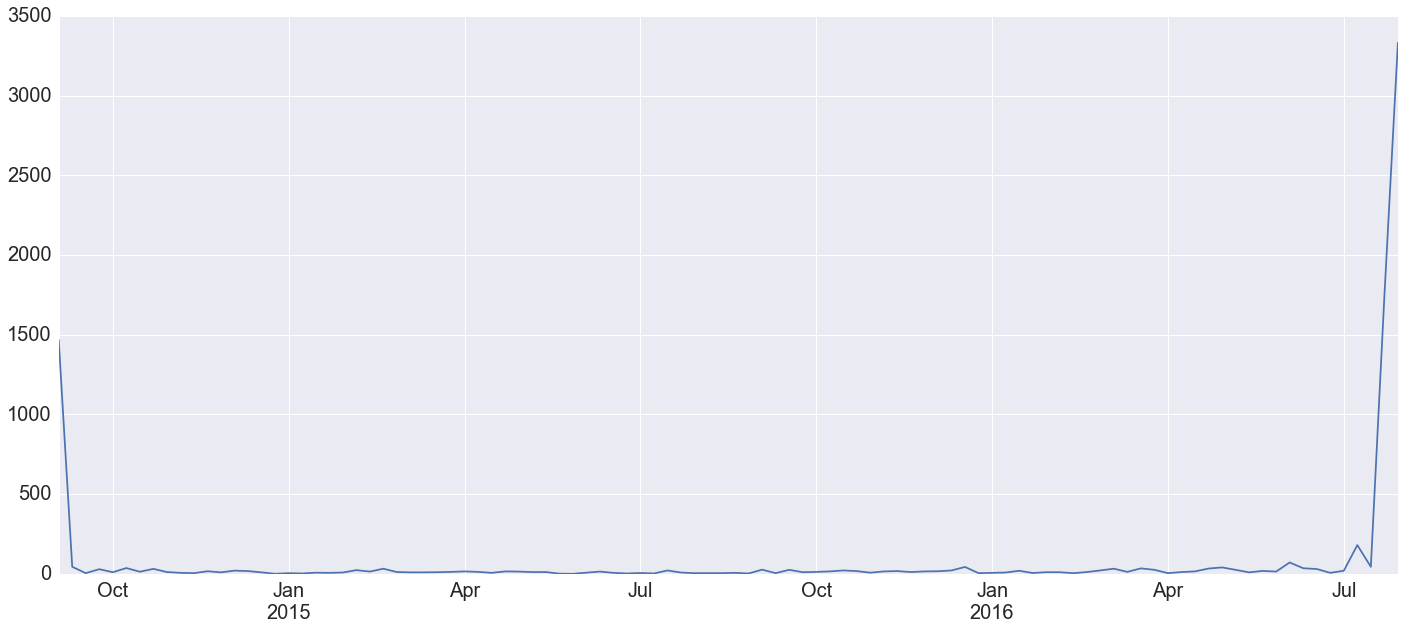

In [60]:
# Endpoints by weekly update recentness.
pd.Series(range(len(endpoints)), index=endpoint_update_dates(endpoints).values).resample('W').count().plot(figsize=(24, 10), fontsize=20)

In [61]:
sorted(endpoint_update_dates(endpoints).values)[0]

numpy.datetime64('2014-09-05T16:57:38.000000000')

Every endpoint was updated at least since September 2014, which seems to imply that there was some software update at around that time which touched and reset this field on every item in the portal. Update history since then is extremely sparse, which makes sense&mdash;everything more recent than a few weeks old is static or irregularly updated data. The recent hump is things that are "current".

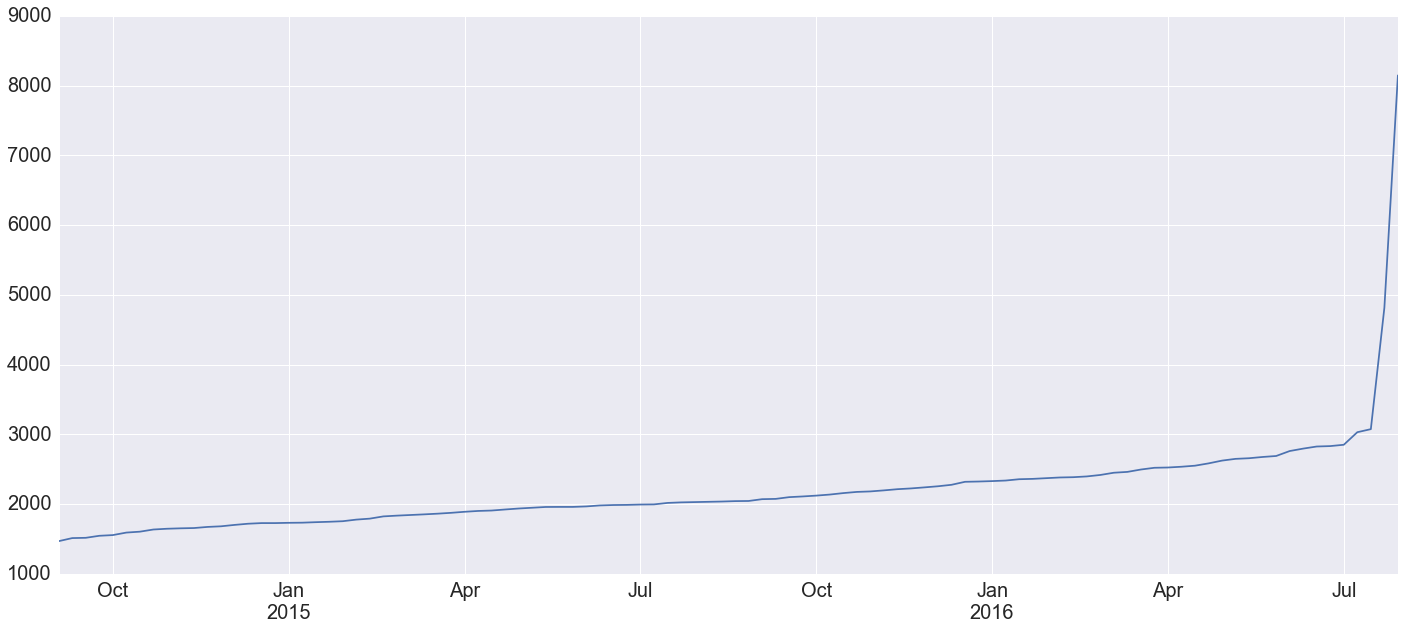

In [62]:
pd.Series(range(len(endpoints)), index=endpoint_update_dates(endpoints).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

**Datasets**

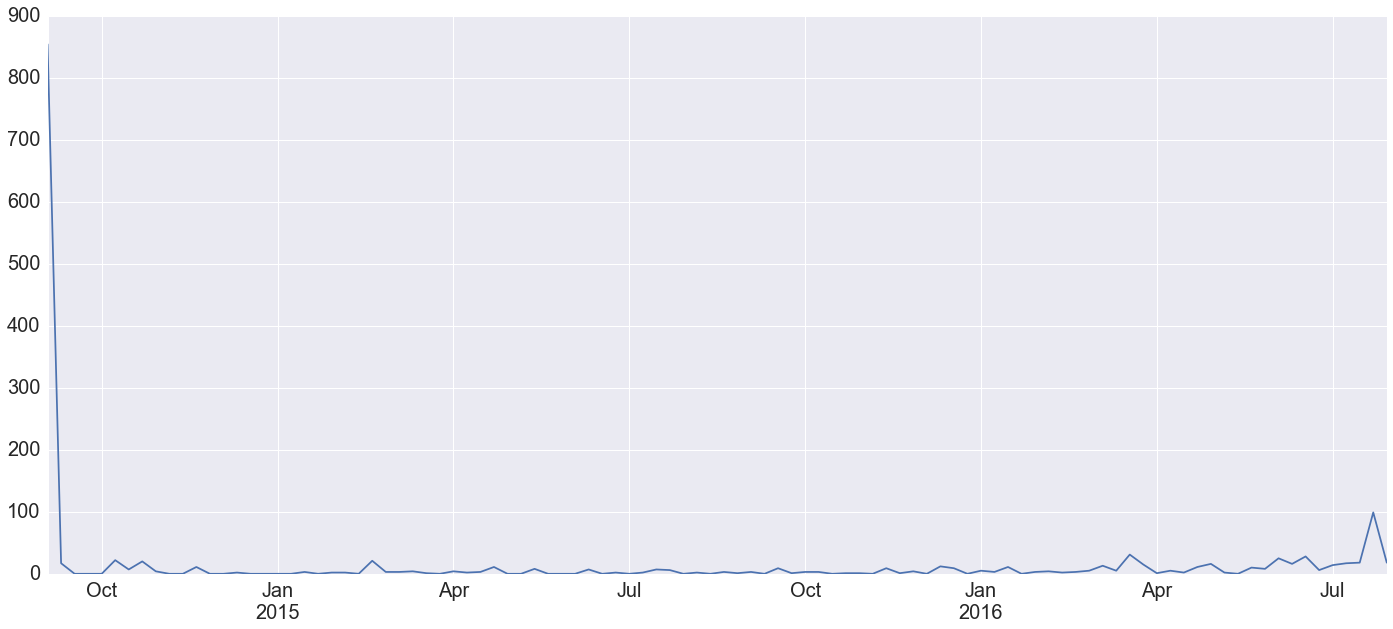

In [63]:
# Weekly updatedAt dates.
pd.Series(range(len(datasets)), index=endpoint_update_dates(datasets).values).resample('W').count().plot(figsize=(24, 10), fontsize=20)

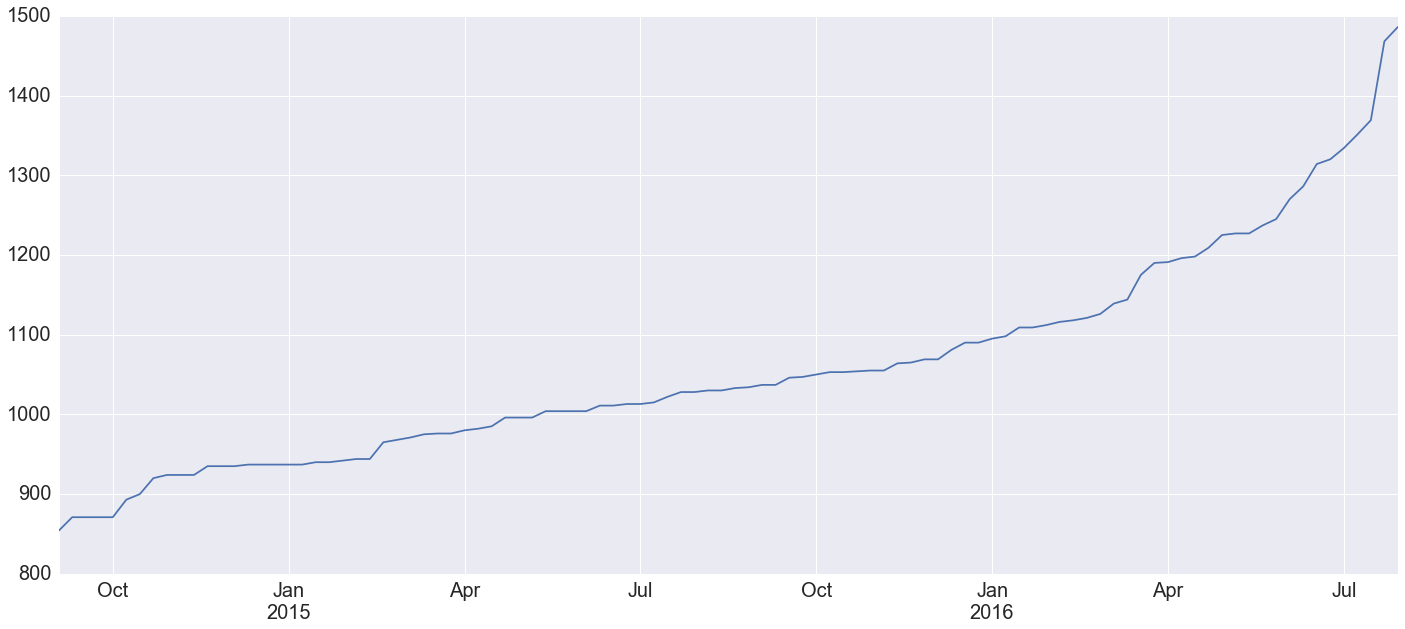

In [64]:
# Weekly updatedAt dates, cumulative.
pd.Series(range(len(datasets)), index=endpoint_update_dates(datasets).values).resample('W').count().cumsum().plot(figsize=(24, 10), fontsize=20)

This plot is more meaningful if we invert. The following plot asks the question: how many datasets were updated in at least the $n$ most recent weeks? This allows us to actually vet the update frequency we are given in the related field against the reality of the Open Data update cycle.

(Note that because of the update issue mentioned above it's not possible to look any further back.)

In [65]:
backwards_facing_cumsum = (len(datasets) - pd.Series(range(len(datasets)), index=endpoint_update_dates(datasets).values).resample('W').count().cumsum())

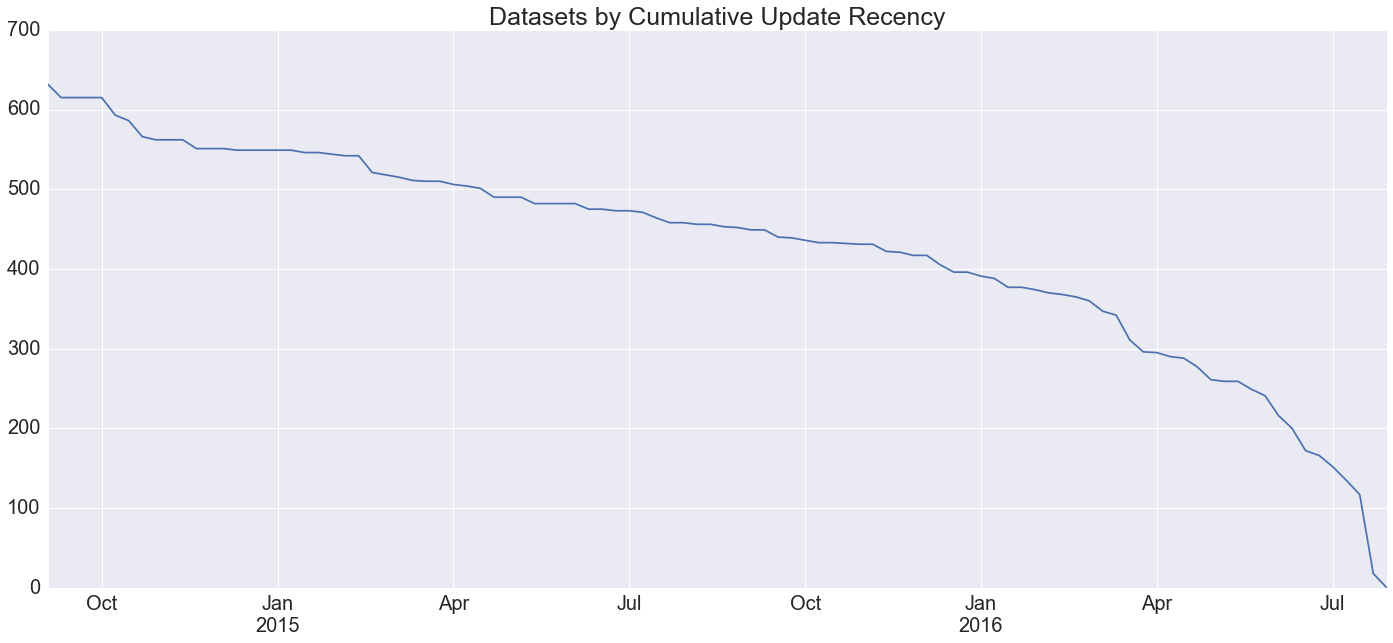

In [121]:
pd.Series(backwards_facing_cumsum).plot(figsize=(24, 10), fontsize=20)
plt.title('Datasets by Cumulative Update Recency', fontsize=25)

### Page views

In [67]:
def endpoint_monthy_page_views(endpoints):
    """
    Returns a pd.Series mapping endpoints to their monthly page views.
    """
    return pd.Series(list(map(lambda srs: srs['resource']['view_count']['page_views_last_month'], endpoints)))

**Endpoints**

In [68]:
endpoint_monthy_page_views(endpoints).sort_values(ascending=False)

0       167921
21       18697
3        13908
1        12959
6        11463
2         5866
112       3038
4         2897
11        2497
12        2406
5         2220
14        2215
88        2138
168       2120
157       2116
175       2062
160       2048
180       2047
181       1968
186       1922
8         1851
179       1817
10        1815
200       1805
210       1721
188       1696
212       1649
209       1648
9         1630
226       1616
         ...  
757          0
7468         0
7469         0
7470         0
7471         0
7472         0
7473         0
7474         0
7475         0
7476         0
7477         0
7478         0
7479         0
7480         0
7481         0
7482         0
7483         0
7484         0
7485         0
7486         0
7487         0
7488         0
7489         0
7490         0
7491         0
7492         0
6329         0
7493         0
7494         0
8144         0
dtype: int64

Unsurprisingly (if you're familiar with these things) the result roughly follows [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), so it has to be visualized as a log plot.

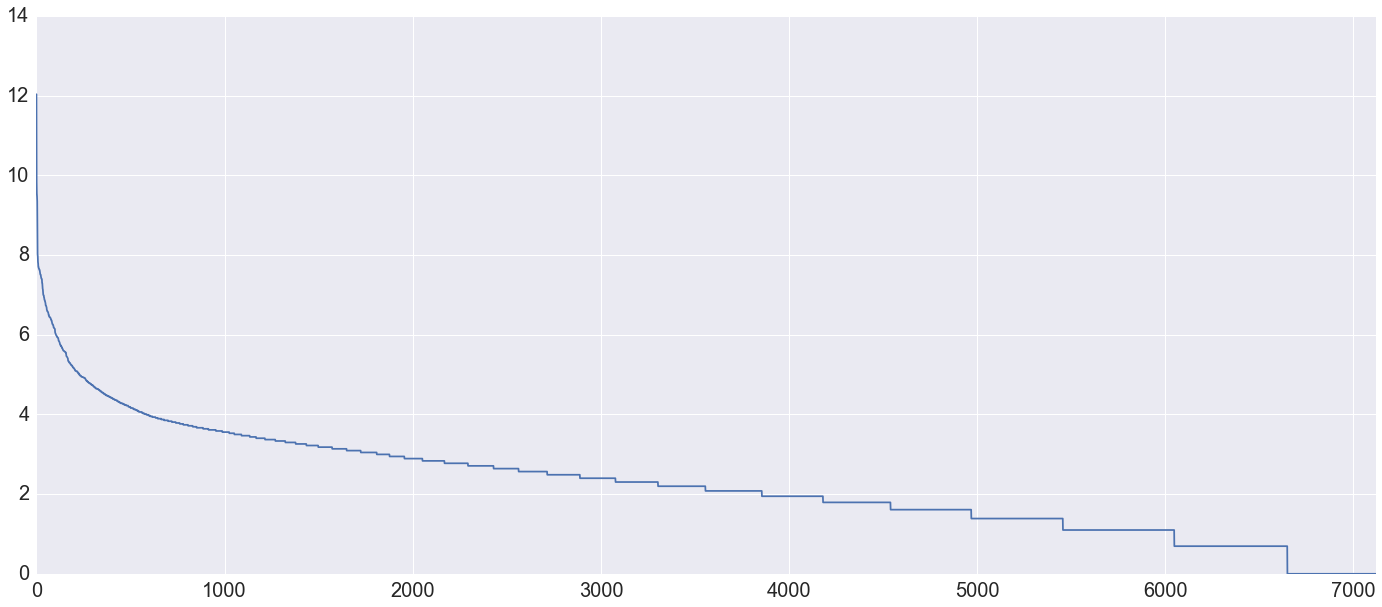

In [69]:
pd.Series(np.log([val for val in endpoint_monthy_page_views(endpoints).sort_values(ascending=False).values if val != 0])).plot(figsize=(24, 10), fontsize=20)

**Datasets**

No different.

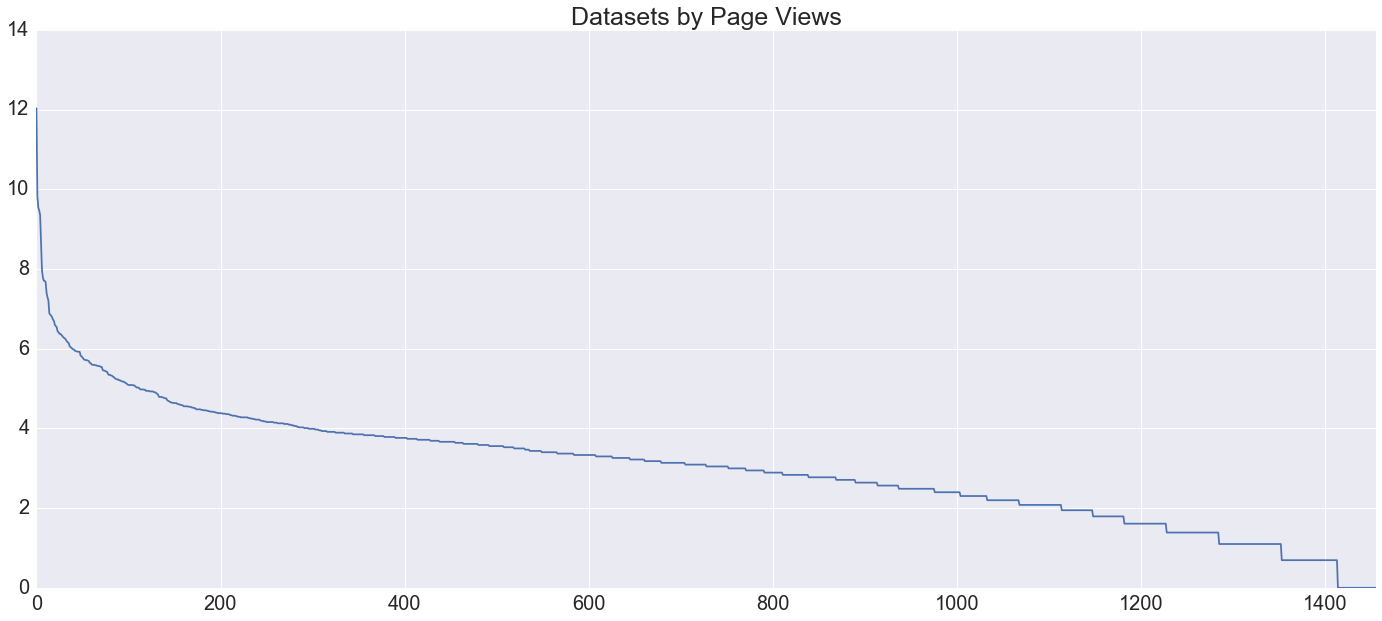

In [131]:
pd.Series(np.log([val for val in endpoint_monthy_page_views(datasets).sort_values(ascending=False).values if val != 0])).plot(figsize=(24, 10), fontsize=20)
plt.title('Datasets by Page Views', fontsize=25)

**Tables**

No different.

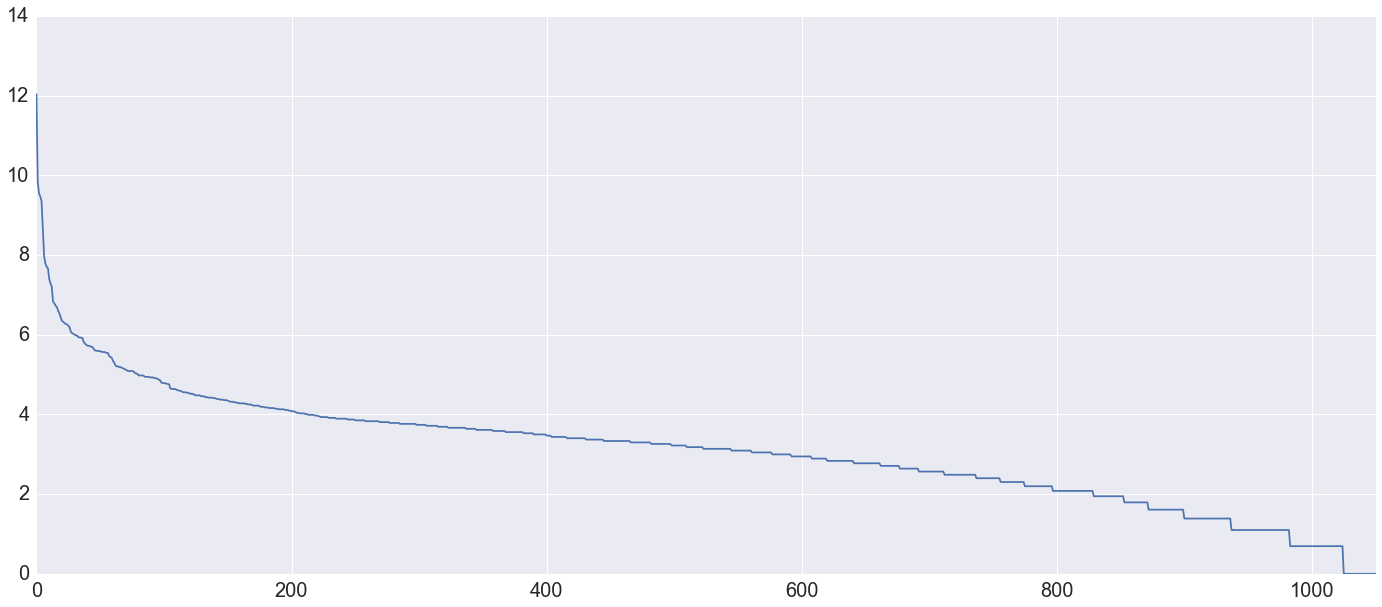

In [71]:
pd.Series(np.log([val for val in endpoint_monthy_page_views(tabular_datasets).sort_values(ascending=False).values if val != 0])).plot(figsize=(24, 10), fontsize=20)

### Resource Type

In [72]:
def endpoint_types(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update dates.
    """
    return pd.Series(list(map(lambda d: d['resource']['type'], endpoints)))

**Endpoints**

Here, `dataset==table`.

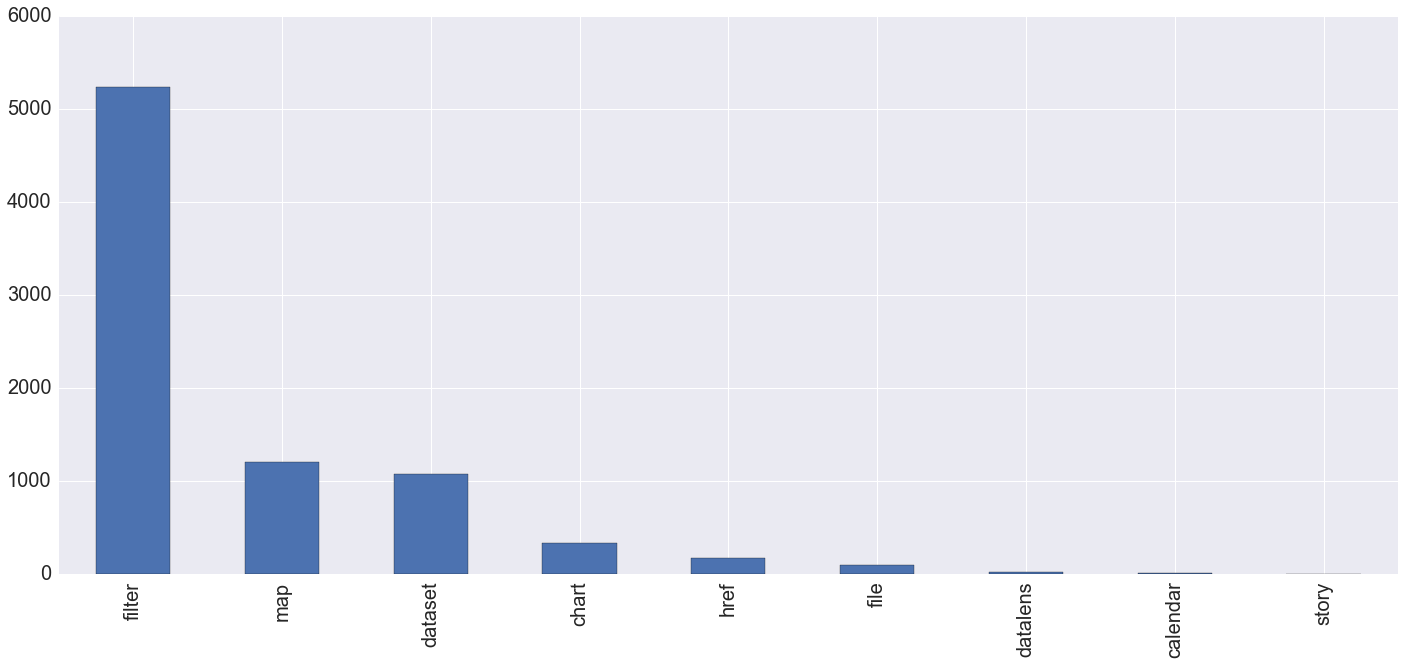

In [73]:
endpoint_types(endpoints).value_counts().plot(kind='bar', figsize=(24, 10), fontsize=20)

Filters are dominated by topic-specific views of 311 call center data, of which there are thousands. These in turn dominate the rest of the data on the portal, at least in terms of raw counts!

### Column names

In [74]:
def endpoint_column_names(endpoints):
    """
    Returns a pd.Series mapping endpoints to their update dates.
    """
    all_columns = []
    for endpoint in endpoints:
        all_columns += endpoint['resource']['columns_name']
    return pd.Series(all_columns)

In [75]:
len(endpoint_column_names(endpoints))

216952

In [76]:
len(endpoint_column_names(tabular_datasets))

15719